In [2]:
# Peter Karras 2020
'''Takes GPP and date information from old master file and creates a new Machine Learning Master File
   With one column representing file names for the converted CSVs and the other column being their respective
   GPPs as pulled from the old master file or calculated with linear interpolation'''

'Takes GPP and date information from old master file and creates a new Machine Learning Master File\n   With one column representing file names for the converted CSVs and the other column being their respective\n   GPPs as pulled from the old master file or calculated with linear interpolation'

In [41]:
import pandas as pd
import os
import csv
import time

In [42]:
# Takes in a string that represents name of csv file and 
# converts that string to one that matches the date string present
# in the old master file (old master file refers to the raw excel file
# filled with extraneous data from BCI)that contains the date/times 
# for recorded GPP values
def change_csv_date(csv):
    minDivFiveFlag = True
    year = csv[2:4]
    month = csv[5:7]
    day = csv[8:10]
    hour = csv[11:13]
    minute = csv[14:16]
    second = "00"
    if (int(minute) % 5) != 0:
        print("THIS:", csv, "minute not divisible by 5")
        minDivFiveFlag = False
    if(int(hour) == 0):
        hour = "0"
    elif(int(hour) < 10):
        hour = hour[1:2]
    # No leading zeroes in day or month
    if(int(month) < 10):
        month = month[1:2]
    if(int(day) < 10):
        day = day[1:2]
    result = month + "/" + day + "/" + year + " " + hour + ":" + minute #+ ":" + second + " " + timeDay
    return result, minDivFiveFlag

# USE MAKE MASTER TO CREATE MULTIPLE populatedGPP files that hold mar, april, may etc

In [43]:
# Function that checks if time/date is at 00 minutes
def check_zero_time_min(csv):
    if csv[14:16] == "00":
        return True
    else:
        return False
#  and 30 minutes
def check_thirty_time_min(csv):
    if csv[14:16] == "30":
        return True
    else:
        return False

In [44]:
# Takes in csv date (in format 'YYYY_MM_DD_HH_MM_bci_t') and checks to see if minutes are divisble by div
def check_csv_date(csv, div):
    result = False
    minute = int(csv[14:16])
    remainder = minute % div
    if(remainder == 0):
        result = True
    else:
        result = False
    return result

In [45]:
print(check_csv_date("2015_03_14_14_00_bci_t.csv",30))

True


In [46]:
print(check_thirty_time_min("2015_03_14_14_30_bci_t.csv"))

True


In [102]:
# Grabs all GPP values and dates from master file (as defined above)
masterfileLocation = r"C:\Users\Peter\Desktop\Thermo_R_Code\FinalThermo\new2"
os.chdir(masterfileLocation)
col_list = ["date", "GPP"]
masterFileName = "all-30min-Apr2018_working.csv"
dateGPPList = pd.read_csv(masterFileName, usecols=col_list) 
dateGPPList = dateGPPList.set_index("date")
csv_file1 = "populatedGPPsFULL.csv"

csvdataLocation = r"C:\Users\Peter\Desktop\Thermo_R_Code\FinalThermo\new2\csvdataFULL\BCIML_Dataset"
(_, _, csvfiles) = next(os.walk(csvdataLocation))
#remove previus populated GPPs file if present
csvfiles.remove("populatedGPPs.csv")
#csvfiles.remove("gpp_file.png")
print(csvfiles[len(csvfiles)-1])
print(len(csvfiles))

# Crude way of removing undesired parts of data (if only certain months wanted etc.)
"""
Files are formatted as such: 2015_04_28_02_15_bci_t
with the first file being: 2015_03_14_13_30_bci_t
and the last file being:   2015_10_01_00_55_bci_t SO BASICALLY UNTIL end of September
"""
# file name wanted
desiredName = "2015"
counter = 0
while counter < len(csvfiles):
    pickedFile = csvfiles[counter]
    if desiredName not in pickedFile:
        del csvfiles[counter]
        counter = counter - 1
    counter = counter + 1
print("fin:",len(csvfiles))


2015_10_01_00_55_bci_t.csv
55374
fin: 55374


In [103]:
# This chunk of code matches the file names from the old master file to the
# names gotten from the "csvdata" folder, so that each thermal csv file has it's
# corresponding GPP value matched to it
# NOTE: In addition to matching GPP values, this code also fills in GPP values
# for those images without recorded values through linear interpoaltion


dictList = list()

counter = 0
numLoops = len(csvfiles)
oldGPP = -1.1
gapCounter = 0
#5448
GPPDataDict = dict()
for i in range(0, numLoops, 6):
    #GPPDataDict.clear()
    currFile = csvfiles[i]
    print("processing step ",i, ":", currFile)
    adaptedDate, minDivFiveFlag = change_csv_date(currFile)
    # If value is not at a 5 minute interval we ignore it (already have pleeenttyy of data)
    if not minDivFiveFlag:
        continue
    # Try to see if our date/time is the start/end of a GPP record (30 min interval)
    # This is done to accomodate for the linear interpolation that occurs later
    try:
        currGPP = dateGPPList.at[adaptedDate,"GPP"]
    except:
        print("Gap in time: ", adaptedDate)
        for num in range(1,6):
            adaptedDate, _ = change_csv_date(csvfiles[i+num])
            try:
                currGPP = dateGPPList.at[adaptedDate,"GPP"]
                break
            except:
                currGPP = -101
        if currGPP == -101:
            continue
            gapCounter += 1
    if(i == 0):
        GPPDataDict.update({"GPP" : currGPP})
        GPPDataDict.update({"FILE" : currFile})
        print("Dict Updated with:",currFile, ":", currGPP)
        dictList.append(GPPDataDict)
        oldGPP = currGPP
        continue
        
    GPPDataDictTemp = dict()
    GPPDataDictTemp.update({"GPP" : currGPP})
    GPPDataDictTemp.update({"FILE" : currFile})
    print("TEMP dict updated with:",currFile, ":", currGPP)

    
    
    diffGPP = currGPP - oldGPP
    increment = diffGPP / 6.0
    
    
#     for j in range(i-5, i, 1):
#         oldGPP += increment
#         currFile = csvfiles[j]
#         #print("Here", currFile)
#         GPPDataDict = dict()
#         GPPDataDict.update({"GPP" : oldGPP})
#         GPPDataDict.update({"FILE" : currFile})
#         dictList.append(GPPDataDict)
        
    # Need 6 values to interpolate correctly aka minutes 5,10,15,20,25,30 or 35,40,45,50,55,0
    countInterPolate = 0
    # j represents current index of file that needs a GPP value estimated through interpolation
    j = i-5
    # Determines what we are looking for, if we are currently at 00, we are looking for previous half hour (going back)
    # so something that has the time xx:30 and vice versa
    lookFor = ""
    if check_thirty_time_min(currFile):
        lookFor = "00"
    else:
        lookFor = "30"
    while countInterPolate != 5:
        currFile = csvfiles[j]
        if not lookFor == "nothing":
            if lookFor == "00":
                if not check_zero_time_min(currFile):
                    j = j-1
                    continue
                else:
                    # Reached 00 time, move onto the next
                    lookFor = "nothing"
                    j = j+1
                    continue
            elif lookFor == "30":
                if not check_thirty_time_min(currFile):
                    j = j-1
                    continue
                else:
                    # Reached 30 time, move onto the next
                    lookFor = "nothing"
                    j = j+1
                    continue
        else:
            currFile = csvfiles[j]
            _, minDivFiveFlag = change_csv_date(currFile)
            # If value not divsible by five, move on!
            if not minDivFiveFlag:
                j = j+1
                continue
            oldGPP += increment

        GPPDataDict = dict()
        GPPDataDict.update({"GPP" : oldGPP})
        GPPDataDict.update({"FILE" : currFile})
        print("Dict Updated with:",currFile, ":", oldGPP)

        dictList.append(GPPDataDict)
        # Reaching this point means we found a valid value, add it to dict and increment index
        countInterPolate = countInterPolate + 1
        j = j+1
        
        
        
    
    dictList.append(GPPDataDictTemp)
    oldGPP = currGPP + increment
    oldGPP = currGPP

processing step  0 : 2015_03_14_13_30_bci_t.csv
Dict Updated with: 2015_03_14_13_30_bci_t.csv : 16.77626799
processing step  6 : 2015_03_14_14_00_bci_t.csv
TEMP dict updated with: 2015_03_14_14_00_bci_t.csv : 16.65037454
Dict Updated with: 2015_03_14_13_35_bci_t.csv : 16.755285748333336
Dict Updated with: 2015_03_14_13_40_bci_t.csv : 16.73430350666667
Dict Updated with: 2015_03_14_13_45_bci_t.csv : 16.713321265000005
Dict Updated with: 2015_03_14_13_50_bci_t.csv : 16.69233902333334
Dict Updated with: 2015_03_14_13_55_bci_t.csv : 16.671356781666674
processing step  12 : 2015_03_14_14_30_bci_t.csv
TEMP dict updated with: 2015_03_14_14_30_bci_t.csv : 16.401061
Dict Updated with: 2015_03_14_14_05_bci_t.csv : 16.608822283333335
Dict Updated with: 2015_03_14_14_10_bci_t.csv : 16.56727002666667
Dict Updated with: 2015_03_14_14_15_bci_t.csv : 16.525717770000004
Dict Updated with: 2015_03_14_14_20_bci_t.csv : 16.484165513333338
Dict Updated with: 2015_03_14_14_25_bci_t.csv : 16.44261325666667
p

Dict Updated with: 2015_03_16_14_05_bci_t.csv : 16.34047923
Dict Updated with: 2015_03_16_14_10_bci_t.csv : 16.31372958
Dict Updated with: 2015_03_16_14_15_bci_t.csv : 16.28697993
Dict Updated with: 2015_03_16_14_20_bci_t.csv : 16.260230280000002
Dict Updated with: 2015_03_16_14_25_bci_t.csv : 16.233480630000003
processing step  594 : 2015_03_16_15_00_bci_t.csv
TEMP dict updated with: 2015_03_16_15_00_bci_t.csv : 14.09481405
Dict Updated with: 2015_03_16_14_35_bci_t.csv : 15.854744825
Dict Updated with: 2015_03_16_14_40_bci_t.csv : 15.502758669999999
Dict Updated with: 2015_03_16_14_45_bci_t.csv : 15.150772514999998
Dict Updated with: 2015_03_16_14_50_bci_t.csv : 14.798786359999998
Dict Updated with: 2015_03_16_14_55_bci_t.csv : 14.446800204999997
processing step  600 : 2015_03_16_15_30_bci_t.csv
TEMP dict updated with: 2015_03_16_15_30_bci_t.csv : 12.76467612
Dict Updated with: 2015_03_16_15_05_bci_t.csv : 13.873124395
Dict Updated with: 2015_03_16_15_10_bci_t.csv : 13.65143474
Dict U

Dict Updated with: 2015_03_18_12_50_bci_t.csv : 12.544200523333338
Dict Updated with: 2015_03_18_12_55_bci_t.csv : 13.059702516666672
processing step  1152 : 2015_03_18_13_30_bci_t.csv
TEMP dict updated with: 2015_03_18_13_30_bci_t.csv : 15.20457229
Dict Updated with: 2015_03_18_13_05_bci_t.csv : 13.846765806666667
Dict Updated with: 2015_03_18_13_10_bci_t.csv : 14.118327103333334
Dict Updated with: 2015_03_18_13_15_bci_t.csv : 14.3898884
Dict Updated with: 2015_03_18_13_20_bci_t.csv : 14.661449696666667
Dict Updated with: 2015_03_18_13_25_bci_t.csv : 14.933010993333333
processing step  1158 : 2015_03_18_14_00_bci_t.csv
TEMP dict updated with: 2015_03_18_14_00_bci_t.csv : 14.12690622
Dict Updated with: 2015_03_18_13_35_bci_t.csv : 15.024961278333333
Dict Updated with: 2015_03_18_13_40_bci_t.csv : 14.845350266666665
Dict Updated with: 2015_03_18_13_45_bci_t.csv : 14.665739254999998
Dict Updated with: 2015_03_18_13_50_bci_t.csv : 14.486128243333331
Dict Updated with: 2015_03_18_13_55_bci

Dict Updated with: 2015_03_20_16_15_bci_t.csv : 11.39501644
Dict Updated with: 2015_03_20_16_20_bci_t.csv : 11.341019376666665
Dict Updated with: 2015_03_20_16_25_bci_t.csv : 11.287022313333331
processing step  1770 : 2015_03_20_17_00_bci_t.csv
TEMP dict updated with: 2015_03_20_17_00_bci_t.csv : 7.818046517000001
Dict Updated with: 2015_03_20_16_35_bci_t.csv : 10.663862127833333
Dict Updated with: 2015_03_20_16_40_bci_t.csv : 10.094699005666666
Dict Updated with: 2015_03_20_16_45_bci_t.csv : 9.525535883499998
Dict Updated with: 2015_03_20_16_50_bci_t.csv : 8.95637276133333
Dict Updated with: 2015_03_20_16_55_bci_t.csv : 8.387209639166663
processing step  1776 : 2015_03_20_17_30_bci_t.csv
TEMP dict updated with: 2015_03_20_17_30_bci_t.csv : 5.46041645
Dict Updated with: 2015_03_20_17_05_bci_t.csv : 7.425108172500001
Dict Updated with: 2015_03_20_17_10_bci_t.csv : 7.032169828000001
Dict Updated with: 2015_03_20_17_15_bci_t.csv : 6.639231483500001
Dict Updated with: 2015_03_20_17_20_bci_

Dict Updated with: 2015_03_23_03_45_bci_t.csv : 0.0
Dict Updated with: 2015_03_23_03_50_bci_t.csv : 0.0
Dict Updated with: 2015_03_23_03_55_bci_t.csv : 0.0
processing step  2484 : 2015_03_23_04_30_bci_t.csv
TEMP dict updated with: 2015_03_23_04_30_bci_t.csv : 0.0
Dict Updated with: 2015_03_23_04_05_bci_t.csv : 0.0
Dict Updated with: 2015_03_23_04_10_bci_t.csv : 0.0
Dict Updated with: 2015_03_23_04_15_bci_t.csv : 0.0
Dict Updated with: 2015_03_23_04_20_bci_t.csv : 0.0
Dict Updated with: 2015_03_23_04_25_bci_t.csv : 0.0
processing step  2490 : 2015_03_23_05_00_bci_t.csv
TEMP dict updated with: 2015_03_23_05_00_bci_t.csv : 0.0
Dict Updated with: 2015_03_23_04_35_bci_t.csv : 0.0
Dict Updated with: 2015_03_23_04_40_bci_t.csv : 0.0
Dict Updated with: 2015_03_23_04_45_bci_t.csv : 0.0
Dict Updated with: 2015_03_23_04_50_bci_t.csv : 0.0
Dict Updated with: 2015_03_23_04_55_bci_t.csv : 0.0
processing step  2496 : 2015_03_23_05_30_bci_t.csv
TEMP dict updated with: 2015_03_23_05_30_bci_t.csv : 0.0


Dict Updated with: 2015_03_25_12_20_bci_t.csv : 18.389666863333336
Dict Updated with: 2015_03_25_12_25_bci_t.csv : 18.54125396666667
processing step  3162 : 2015_03_25_13_00_bci_t.csv
TEMP dict updated with: 2015_03_25_13_00_bci_t.csv : 17.02292531
Dict Updated with: 2015_03_25_12_35_bci_t.csv : 18.414521776666668
Dict Updated with: 2015_03_25_12_40_bci_t.csv : 18.136202483333335
Dict Updated with: 2015_03_25_12_45_bci_t.csv : 17.857883190000003
Dict Updated with: 2015_03_25_12_50_bci_t.csv : 17.57956389666667
Dict Updated with: 2015_03_25_12_55_bci_t.csv : 17.301244603333338
processing step  3168 : 2015_03_25_13_30_bci_t.csv
TEMP dict updated with: 2015_03_25_13_30_bci_t.csv : 17.10911416
Dict Updated with: 2015_03_25_13_05_bci_t.csv : 17.037290118333335
Dict Updated with: 2015_03_25_13_10_bci_t.csv : 17.051654926666668
Dict Updated with: 2015_03_25_13_15_bci_t.csv : 17.066019735
Dict Updated with: 2015_03_25_13_20_bci_t.csv : 17.080384543333334
Dict Updated with: 2015_03_25_13_25_bci

Dict Updated with: 2015_03_27_22_55_bci_t.csv : 0.0
processing step  3864 : 2015_03_27_23_30_bci_t.csv
TEMP dict updated with: 2015_03_27_23_30_bci_t.csv : 0.0
Dict Updated with: 2015_03_27_23_05_bci_t.csv : 0.0
Dict Updated with: 2015_03_27_23_10_bci_t.csv : 0.0
Dict Updated with: 2015_03_27_23_15_bci_t.csv : 0.0
Dict Updated with: 2015_03_27_23_20_bci_t.csv : 0.0
Dict Updated with: 2015_03_27_23_25_bci_t.csv : 0.0
processing step  3870 : 2015_03_28_00_00_bci_t.csv
TEMP dict updated with: 2015_03_28_00_00_bci_t.csv : 0.0
Dict Updated with: 2015_03_27_23_35_bci_t.csv : 0.0
Dict Updated with: 2015_03_27_23_40_bci_t.csv : 0.0
Dict Updated with: 2015_03_27_23_45_bci_t.csv : 0.0
Dict Updated with: 2015_03_27_23_50_bci_t.csv : 0.0
Dict Updated with: 2015_03_27_23_55_bci_t.csv : 0.0
processing step  3876 : 2015_03_28_00_30_bci_t.csv
TEMP dict updated with: 2015_03_28_00_30_bci_t.csv : 0.0
Dict Updated with: 2015_03_28_00_05_bci_t.csv : 0.0
Dict Updated with: 2015_03_28_00_10_bci_t.csv : 0.0


Dict Updated with: 2015_03_30_08_25_bci_t.csv : 18.229247445
processing step  4554 : 2015_03_30_09_00_bci_t.csv
TEMP dict updated with: 2015_03_30_09_00_bci_t.csv : 20.71523982
Dict Updated with: 2015_03_30_08_35_bci_t.csv : 19.05881042833333
Dict Updated with: 2015_03_30_08_40_bci_t.csv : 19.390096306666663
Dict Updated with: 2015_03_30_08_45_bci_t.csv : 19.721382184999996
Dict Updated with: 2015_03_30_08_50_bci_t.csv : 20.05266806333333
Dict Updated with: 2015_03_30_08_55_bci_t.csv : 20.38395394166666
processing step  4560 : 2015_03_30_09_30_bci_t.csv
TEMP dict updated with: 2015_03_30_09_30_bci_t.csv : 22.17919185
Dict Updated with: 2015_03_30_09_05_bci_t.csv : 20.959231825
Dict Updated with: 2015_03_30_09_10_bci_t.csv : 21.20322383
Dict Updated with: 2015_03_30_09_15_bci_t.csv : 21.447215834999998
Dict Updated with: 2015_03_30_09_20_bci_t.csv : 21.691207839999997
Dict Updated with: 2015_03_30_09_25_bci_t.csv : 21.935199844999996
processing step  4566 : 2015_03_30_10_00_bci_t.csv
TE

Dict Updated with: 2015_04_01_22_55_bci_t.csv : 0.0
processing step  5304 : 2015_04_01_23_30_bci_t.csv
TEMP dict updated with: 2015_04_01_23_30_bci_t.csv : 0.0
Dict Updated with: 2015_04_01_23_05_bci_t.csv : 0.0
Dict Updated with: 2015_04_01_23_10_bci_t.csv : 0.0
Dict Updated with: 2015_04_01_23_15_bci_t.csv : 0.0
Dict Updated with: 2015_04_01_23_20_bci_t.csv : 0.0
Dict Updated with: 2015_04_01_23_25_bci_t.csv : 0.0
processing step  5310 : 2015_04_02_00_00_bci_t.csv
TEMP dict updated with: 2015_04_02_00_00_bci_t.csv : 0.0
Dict Updated with: 2015_04_01_23_35_bci_t.csv : 0.0
Dict Updated with: 2015_04_01_23_40_bci_t.csv : 0.0
Dict Updated with: 2015_04_01_23_45_bci_t.csv : 0.0
Dict Updated with: 2015_04_01_23_50_bci_t.csv : 0.0
Dict Updated with: 2015_04_01_23_55_bci_t.csv : 0.0
processing step  5316 : 2015_04_02_00_30_bci_t.csv
TEMP dict updated with: 2015_04_02_00_30_bci_t.csv : 0.0
Dict Updated with: 2015_04_02_00_05_bci_t.csv : 0.0
Dict Updated with: 2015_04_02_00_10_bci_t.csv : 0.0


Gap in time:  4/4/15 1:10
TEMP dict updated with: 2015_04_04_01_10_bci_t.csv : 0.0
Dict Updated with: 2015_04_04_00_35_bci_t.csv : 0.0
Dict Updated with: 2015_04_04_00_40_bci_t.csv : 0.0
Dict Updated with: 2015_04_04_00_45_bci_t.csv : 0.0
Dict Updated with: 2015_04_04_00_50_bci_t.csv : 0.0
Dict Updated with: 2015_04_04_00_55_bci_t.csv : 0.0
processing step  6048 : 2015_04_04_01_40_bci_t.csv
Gap in time:  4/4/15 1:40
TEMP dict updated with: 2015_04_04_01_40_bci_t.csv : 0.0
Dict Updated with: 2015_04_04_00_35_bci_t.csv : 0.0
Dict Updated with: 2015_04_04_00_40_bci_t.csv : 0.0
Dict Updated with: 2015_04_04_00_45_bci_t.csv : 0.0
Dict Updated with: 2015_04_04_00_50_bci_t.csv : 0.0
Dict Updated with: 2015_04_04_00_55_bci_t.csv : 0.0
processing step  6054 : 2015_04_04_02_10_bci_t.csv
Gap in time:  4/4/15 2:10
TEMP dict updated with: 2015_04_04_02_10_bci_t.csv : 0.0
Dict Updated with: 2015_04_04_01_35_bci_t.csv : 0.0
Dict Updated with: 2015_04_04_01_40_bci_t.csv : 0.0
Dict Updated with: 2015_0

processing step  6714 : 2015_04_06_09_10_bci_t.csv
Gap in time:  4/6/15 9:10
TEMP dict updated with: 2015_04_06_09_10_bci_t.csv : 16.97137499
Dict Updated with: 2015_04_06_08_35_bci_t.csv : 18.049155606666666
Dict Updated with: 2015_04_06_08_40_bci_t.csv : 17.833599483333334
Dict Updated with: 2015_04_06_08_45_bci_t.csv : 17.61804336
Dict Updated with: 2015_04_06_08_50_bci_t.csv : 17.40248723666667
Dict Updated with: 2015_04_06_08_55_bci_t.csv : 17.186931113333337
processing step  6720 : 2015_04_06_09_40_bci_t.csv
Gap in time:  4/6/15 9:40
TEMP dict updated with: 2015_04_06_09_40_bci_t.csv : 17.58070241
Dict Updated with: 2015_04_06_08_35_bci_t.csv : 17.072929560000002
Dict Updated with: 2015_04_06_08_40_bci_t.csv : 17.174484130000003
Dict Updated with: 2015_04_06_08_45_bci_t.csv : 17.276038700000004
Dict Updated with: 2015_04_06_08_50_bci_t.csv : 17.377593270000006
Dict Updated with: 2015_04_06_08_55_bci_t.csv : 17.479147840000007
processing step  6726 : 2015_04_06_10_10_bci_t.csv
Gap

Dict Updated with: 2015_04_08_14_50_bci_t.csv : 13.525597393333332
Dict Updated with: 2015_04_08_14_55_bci_t.csv : 13.070998966666664
processing step  7374 : 2015_04_08_16_10_bci_t.csv
Gap in time:  4/8/15 16:10
TEMP dict updated with: 2015_04_08_16_10_bci_t.csv : 12.74223222
Dict Updated with: 2015_04_08_15_35_bci_t.csv : 12.637372486666667
Dict Updated with: 2015_04_08_15_40_bci_t.csv : 12.658344433333333
Dict Updated with: 2015_04_08_15_45_bci_t.csv : 12.67931638
Dict Updated with: 2015_04_08_15_50_bci_t.csv : 12.700288326666666
Dict Updated with: 2015_04_08_15_55_bci_t.csv : 12.721260273333332
processing step  7380 : 2015_04_08_16_40_bci_t.csv
Gap in time:  4/8/15 16:40
TEMP dict updated with: 2015_04_08_16_40_bci_t.csv : 9.26487508
Dict Updated with: 2015_04_08_15_35_bci_t.csv : 12.162672696666666
Dict Updated with: 2015_04_08_15_40_bci_t.csv : 11.583113173333333
Dict Updated with: 2015_04_08_15_45_bci_t.csv : 11.003553649999999
Dict Updated with: 2015_04_08_15_50_bci_t.csv : 10.4

TEMP dict updated with: 2015_04_10_22_10_bci_t.csv : 0.0
Dict Updated with: 2015_04_10_21_35_bci_t.csv : 0.0
Dict Updated with: 2015_04_10_21_40_bci_t.csv : 0.0
Dict Updated with: 2015_04_10_21_45_bci_t.csv : 0.0
Dict Updated with: 2015_04_10_21_50_bci_t.csv : 0.0
Dict Updated with: 2015_04_10_21_55_bci_t.csv : 0.0
processing step  8028 : 2015_04_10_22_40_bci_t.csv
Gap in time:  4/10/15 22:40
TEMP dict updated with: 2015_04_10_22_40_bci_t.csv : 0.0
Dict Updated with: 2015_04_10_21_35_bci_t.csv : 0.0
Dict Updated with: 2015_04_10_21_40_bci_t.csv : 0.0
Dict Updated with: 2015_04_10_21_45_bci_t.csv : 0.0
Dict Updated with: 2015_04_10_21_50_bci_t.csv : 0.0
Dict Updated with: 2015_04_10_21_55_bci_t.csv : 0.0
processing step  8034 : 2015_04_10_23_10_bci_t.csv
Gap in time:  4/10/15 23:10
TEMP dict updated with: 2015_04_10_23_10_bci_t.csv : 0.0
Dict Updated with: 2015_04_10_22_35_bci_t.csv : 0.0
Dict Updated with: 2015_04_10_22_40_bci_t.csv : 0.0
Dict Updated with: 2015_04_10_22_45_bci_t.csv :

Gap in time:  4/13/15 6:10
TEMP dict updated with: 2015_04_13_06_10_bci_t.csv : 4.78597187
Dict Updated with: 2015_04_13_05_35_bci_t.csv : 0.7976619783333333
Dict Updated with: 2015_04_13_05_40_bci_t.csv : 1.5953239566666666
Dict Updated with: 2015_04_13_05_45_bci_t.csv : 2.392985935
Dict Updated with: 2015_04_13_05_50_bci_t.csv : 3.190647913333333
Dict Updated with: 2015_04_13_05_55_bci_t.csv : 3.9883098916666664
processing step  8700 : 2015_04_13_06_40_bci_t.csv
Gap in time:  4/13/15 6:40
TEMP dict updated with: 2015_04_13_06_40_bci_t.csv : 10.50150077
Dict Updated with: 2015_04_13_05_35_bci_t.csv : 5.7385600199999995
Dict Updated with: 2015_04_13_05_40_bci_t.csv : 6.69114817
Dict Updated with: 2015_04_13_05_45_bci_t.csv : 7.64373632
Dict Updated with: 2015_04_13_05_50_bci_t.csv : 8.59632447
Dict Updated with: 2015_04_13_05_55_bci_t.csv : 9.548912620000001
processing step  8706 : 2015_04_13_07_10_bci_t.csv
Gap in time:  4/13/15 7:10
TEMP dict updated with: 2015_04_13_07_10_bci_t.csv 

Dict Updated with: 2015_04_15_09_55_bci_t.csv : 20.521419578333337
processing step  9324 : 2015_04_15_10_40_bci_t.csv
Gap in time:  4/15/15 10:40
TEMP dict updated with: 2015_04_15_10_40_bci_t.csv : 23.00535442
Dict Updated with: 2015_04_15_09_35_bci_t.csv : 20.794487445
Dict Updated with: 2015_04_15_09_40_bci_t.csv : 21.236660840000003
Dict Updated with: 2015_04_15_09_45_bci_t.csv : 21.678834235000004
Dict Updated with: 2015_04_15_09_50_bci_t.csv : 22.121007630000005
Dict Updated with: 2015_04_15_09_55_bci_t.csv : 22.563181025000006
processing step  9330 : 2015_04_15_11_10_bci_t.csv
Gap in time:  4/15/15 11:10
TEMP dict updated with: 2015_04_15_11_10_bci_t.csv : 23.102770800000002
Dict Updated with: 2015_04_15_10_35_bci_t.csv : 23.021590483333334
Dict Updated with: 2015_04_15_10_40_bci_t.csv : 23.03782654666667
Dict Updated with: 2015_04_15_10_45_bci_t.csv : 23.054062610000003
Dict Updated with: 2015_04_15_10_50_bci_t.csv : 23.070298673333337
Dict Updated with: 2015_04_15_10_55_bci_t.

Dict Updated with: 2015_04_17_15_50_bci_t.csv : 17.496675380000006
Dict Updated with: 2015_04_17_15_55_bci_t.csv : 16.869256735000008
processing step  9972 : 2015_04_17_16_40_bci_t.csv
Gap in time:  4/17/15 16:40
TEMP dict updated with: 2015_04_17_16_40_bci_t.csv : 10.86189885
Dict Updated with: 2015_04_17_15_35_bci_t.csv : 15.345181550000001
Dict Updated with: 2015_04_17_15_40_bci_t.csv : 14.448525010000001
Dict Updated with: 2015_04_17_15_45_bci_t.csv : 13.55186847
Dict Updated with: 2015_04_17_15_50_bci_t.csv : 12.65521193
Dict Updated with: 2015_04_17_15_55_bci_t.csv : 11.75855539
processing step  9978 : 2015_04_17_17_10_bci_t.csv
Gap in time:  4/17/15 17:10
TEMP dict updated with: 2015_04_17_17_10_bci_t.csv : 7.236005625
Dict Updated with: 2015_04_17_16_35_bci_t.csv : 10.2575833125
Dict Updated with: 2015_04_17_16_40_bci_t.csv : 9.653267775
Dict Updated with: 2015_04_17_16_45_bci_t.csv : 9.0489522375
Dict Updated with: 2015_04_17_16_50_bci_t.csv : 8.4446367
Dict Updated with: 2015

Dict Updated with: 2015_04_19_21_40_bci_t.csv : 0.0
Dict Updated with: 2015_04_19_21_45_bci_t.csv : 0.0
Dict Updated with: 2015_04_19_21_50_bci_t.csv : 0.0
Dict Updated with: 2015_04_19_21_55_bci_t.csv : 0.0
processing step  10626 : 2015_04_19_23_10_bci_t.csv
Gap in time:  4/19/15 23:10
TEMP dict updated with: 2015_04_19_23_10_bci_t.csv : 0.0
Dict Updated with: 2015_04_19_22_35_bci_t.csv : 0.0
Dict Updated with: 2015_04_19_22_40_bci_t.csv : 0.0
Dict Updated with: 2015_04_19_22_45_bci_t.csv : 0.0
Dict Updated with: 2015_04_19_22_50_bci_t.csv : 0.0
Dict Updated with: 2015_04_19_22_55_bci_t.csv : 0.0
processing step  10632 : 2015_04_19_23_40_bci_t.csv
Gap in time:  4/19/15 23:40
TEMP dict updated with: 2015_04_19_23_40_bci_t.csv : 0.0
Dict Updated with: 2015_04_19_22_35_bci_t.csv : 0.0
Dict Updated with: 2015_04_19_22_40_bci_t.csv : 0.0
Dict Updated with: 2015_04_19_22_45_bci_t.csv : 0.0
Dict Updated with: 2015_04_19_22_50_bci_t.csv : 0.0
Dict Updated with: 2015_04_19_22_55_bci_t.csv : 0.

TEMP dict updated with: 2015_04_22_03_10_bci_t.csv : 0.0
Dict Updated with: 2015_04_22_02_35_bci_t.csv : 0.0
Dict Updated with: 2015_04_22_02_40_bci_t.csv : 0.0
Dict Updated with: 2015_04_22_02_45_bci_t.csv : 0.0
Dict Updated with: 2015_04_22_02_50_bci_t.csv : 0.0
Dict Updated with: 2015_04_22_02_55_bci_t.csv : 0.0
processing step  11256 : 2015_04_22_03_40_bci_t.csv
Gap in time:  4/22/15 3:40
TEMP dict updated with: 2015_04_22_03_40_bci_t.csv : 0.0
Dict Updated with: 2015_04_22_02_35_bci_t.csv : 0.0
Dict Updated with: 2015_04_22_02_40_bci_t.csv : 0.0
Dict Updated with: 2015_04_22_02_45_bci_t.csv : 0.0
Dict Updated with: 2015_04_22_02_50_bci_t.csv : 0.0
Dict Updated with: 2015_04_22_02_55_bci_t.csv : 0.0
processing step  11262 : 2015_04_22_04_10_bci_t.csv
Gap in time:  4/22/15 4:10
TEMP dict updated with: 2015_04_22_04_10_bci_t.csv : 0.0
Dict Updated with: 2015_04_22_03_35_bci_t.csv : 0.0
Dict Updated with: 2015_04_22_03_40_bci_t.csv : 0.0
Dict Updated with: 2015_04_22_03_45_bci_t.csv :

Dict Updated with: 2015_04_25_08_55_bci_t.csv : 26.105509315000003
processing step  12192 : 2015_04_25_09_40_bci_t.csv
Gap in time:  4/25/15 9:40
TEMP dict updated with: 2015_04_25_09_40_bci_t.csv : 28.01939231
Dict Updated with: 2015_04_25_08_35_bci_t.csv : 27.805759943333335
Dict Updated with: 2015_04_25_08_40_bci_t.csv : 27.848486416666667
Dict Updated with: 2015_04_25_08_45_bci_t.csv : 27.89121289
Dict Updated with: 2015_04_25_08_50_bci_t.csv : 27.93393936333333
Dict Updated with: 2015_04_25_08_55_bci_t.csv : 27.976665836666662
processing step  12198 : 2015_04_25_10_10_bci_t.csv
Gap in time:  4/25/15 10:10
TEMP dict updated with: 2015_04_25_10_10_bci_t.csv : 25.67117816
Dict Updated with: 2015_04_25_09_35_bci_t.csv : 27.628023285
Dict Updated with: 2015_04_25_09_40_bci_t.csv : 27.23665426
Dict Updated with: 2015_04_25_09_45_bci_t.csv : 26.845285235000002
Dict Updated with: 2015_04_25_09_50_bci_t.csv : 26.453916210000003
Dict Updated with: 2015_04_25_09_55_bci_t.csv : 26.06254718500

Dict Updated with: 2015_04_27_10_55_bci_t.csv : 23.836495446666667
processing step  12792 : 2015_04_27_11_40_bci_t.csv
Gap in time:  4/27/15 11:40
TEMP dict updated with: 2015_04_27_11_40_bci_t.csv : 23.94332189
Dict Updated with: 2015_04_27_10_35_bci_t.csv : 23.797842598333332
Dict Updated with: 2015_04_27_10_40_bci_t.csv : 23.826938456666667
Dict Updated with: 2015_04_27_10_45_bci_t.csv : 23.856034315000002
Dict Updated with: 2015_04_27_10_50_bci_t.csv : 23.885130173333337
Dict Updated with: 2015_04_27_10_55_bci_t.csv : 23.914226031666672
processing step  12798 : 2015_04_27_12_10_bci_t.csv
Gap in time:  4/27/15 12:10
TEMP dict updated with: 2015_04_27_12_10_bci_t.csv : 27.70379017
Dict Updated with: 2015_04_27_11_35_bci_t.csv : 24.570066603333334
Dict Updated with: 2015_04_27_11_40_bci_t.csv : 25.19681131666667
Dict Updated with: 2015_04_27_11_45_bci_t.csv : 25.823556030000002
Dict Updated with: 2015_04_27_11_50_bci_t.csv : 26.450300743333337
Dict Updated with: 2015_04_27_11_55_bci_t

Gap in time:  4/29/15 12:40
TEMP dict updated with: 2015_04_29_12_40_bci_t.csv : 18.63347381
Dict Updated with: 2015_04_29_11_35_bci_t.csv : 17.567201776666668
Dict Updated with: 2015_04_29_11_40_bci_t.csv : 17.780456183333335
Dict Updated with: 2015_04_29_11_45_bci_t.csv : 17.993710590000003
Dict Updated with: 2015_04_29_11_50_bci_t.csv : 18.20696499666667
Dict Updated with: 2015_04_29_11_55_bci_t.csv : 18.420219403333338
processing step  13386 : 2015_04_29_13_10_bci_t.csv
Gap in time:  4/29/15 13:10
TEMP dict updated with: 2015_04_29_13_10_bci_t.csv : 20.50659563
Dict Updated with: 2015_04_29_12_35_bci_t.csv : 18.94566078
Dict Updated with: 2015_04_29_12_40_bci_t.csv : 19.25784775
Dict Updated with: 2015_04_29_12_45_bci_t.csv : 19.57003472
Dict Updated with: 2015_04_29_12_50_bci_t.csv : 19.882221689999998
Dict Updated with: 2015_04_29_12_55_bci_t.csv : 20.194408659999997
processing step  13392 : 2015_04_29_13_40_bci_t.csv
Gap in time:  4/29/15 13:40
TEMP dict updated with: 2015_04_29

Dict Updated with: 2015_05_01_13_50_bci_t.csv : 2.6093828476666667
Dict Updated with: 2015_05_01_13_55_bci_t.csv : 2.4848857283333334
processing step  13986 : 2015_05_01_15_10_bci_t.csv
Gap in time:  5/1/15 15:10
TEMP dict updated with: 2015_05_01_15_10_bci_t.csv : 2.973610088
Dict Updated with: 2015_05_01_14_35_bci_t.csv : 2.4625921888333333
Dict Updated with: 2015_05_01_14_40_bci_t.csv : 2.5647957686666665
Dict Updated with: 2015_05_01_14_45_bci_t.csv : 2.6669993484999996
Dict Updated with: 2015_05_01_14_50_bci_t.csv : 2.769202928333333
Dict Updated with: 2015_05_01_14_55_bci_t.csv : 2.871406508166666
processing step  13992 : 2015_05_01_15_40_bci_t.csv
Gap in time:  5/1/15 15:40
TEMP dict updated with: 2015_05_01_15_40_bci_t.csv : 2.980305157
Dict Updated with: 2015_05_01_14_35_bci_t.csv : 2.9747259328333335
Dict Updated with: 2015_05_01_14_40_bci_t.csv : 2.975841777666667
Dict Updated with: 2015_05_01_14_45_bci_t.csv : 2.9769576225000005
Dict Updated with: 2015_05_01_14_50_bci_t.csv

TEMP dict updated with: 2015_05_03_09_10_bci_t.csv : 24.46144092
Dict Updated with: 2015_05_03_08_35_bci_t.csv : 23.345745811666667
Dict Updated with: 2015_05_03_08_40_bci_t.csv : 23.568884833333335
Dict Updated with: 2015_05_03_08_45_bci_t.csv : 23.792023855000004
Dict Updated with: 2015_05_03_08_50_bci_t.csv : 24.015162876666672
Dict Updated with: 2015_05_03_08_55_bci_t.csv : 24.23830189833334
processing step  14496 : 2015_05_03_09_40_bci_t.csv
Gap in time:  5/3/15 9:40
TEMP dict updated with: 2015_05_03_09_40_bci_t.csv : 12.6479871
Dict Updated with: 2015_05_03_08_35_bci_t.csv : 22.49253195
Dict Updated with: 2015_05_03_08_40_bci_t.csv : 20.52362298
Dict Updated with: 2015_05_03_08_45_bci_t.csv : 18.554714009999998
Dict Updated with: 2015_05_03_08_50_bci_t.csv : 16.585805039999997
Dict Updated with: 2015_05_03_08_55_bci_t.csv : 14.616896069999996
processing step  14502 : 2015_05_03_10_10_bci_t.csv
Gap in time:  5/3/15 10:10
TEMP dict updated with: 2015_05_03_10_10_bci_t.csv : 17.268

Gap in time:  5/5/15 11:10
TEMP dict updated with: 2015_05_05_11_10_bci_t.csv : 27.424444
Dict Updated with: 2015_05_05_10_35_bci_t.csv : 25.741370016666664
Dict Updated with: 2015_05_05_10_40_bci_t.csv : 26.07798481333333
Dict Updated with: 2015_05_05_10_45_bci_t.csv : 26.414599609999996
Dict Updated with: 2015_05_05_10_50_bci_t.csv : 26.751214406666662
Dict Updated with: 2015_05_05_10_55_bci_t.csv : 27.087829203333328
processing step  15096 : 2015_05_05_11_40_bci_t.csv
Gap in time:  5/5/15 11:40
TEMP dict updated with: 2015_05_05_11_40_bci_t.csv : 24.36302884
Dict Updated with: 2015_05_05_10_35_bci_t.csv : 26.91420814
Dict Updated with: 2015_05_05_10_40_bci_t.csv : 26.403972279999998
Dict Updated with: 2015_05_05_10_45_bci_t.csv : 25.893736419999996
Dict Updated with: 2015_05_05_10_50_bci_t.csv : 25.383500559999995
Dict Updated with: 2015_05_05_10_55_bci_t.csv : 24.873264699999993
processing step  15102 : 2015_05_05_12_10_bci_t.csv
Gap in time:  5/5/15 12:10
TEMP dict updated with: 2

TEMP dict updated with: 2015_05_07_11_10_bci_t.csv : 26.13879736
Dict Updated with: 2015_05_07_10_35_bci_t.csv : 22.887448501666668
Dict Updated with: 2015_05_07_10_40_bci_t.csv : 23.537718273333336
Dict Updated with: 2015_05_07_10_45_bci_t.csv : 24.187988045000004
Dict Updated with: 2015_05_07_10_50_bci_t.csv : 24.838257816666673
Dict Updated with: 2015_05_07_10_55_bci_t.csv : 25.48852758833334
processing step  15672 : 2015_05_07_11_40_bci_t.csv
Gap in time:  5/7/15 11:40
TEMP dict updated with: 2015_05_07_11_40_bci_t.csv : 23.43365513
Dict Updated with: 2015_05_07_10_35_bci_t.csv : 25.68794032166667
Dict Updated with: 2015_05_07_10_40_bci_t.csv : 25.237083283333337
Dict Updated with: 2015_05_07_10_45_bci_t.csv : 24.786226245000005
Dict Updated with: 2015_05_07_10_50_bci_t.csv : 24.335369206666673
Dict Updated with: 2015_05_07_10_55_bci_t.csv : 23.88451216833334
processing step  15678 : 2015_05_07_12_10_bci_t.csv
Gap in time:  5/7/15 12:10
TEMP dict updated with: 2015_05_07_12_10_bci_

Gap in time:  5/9/15 14:40
TEMP dict updated with: 2015_05_09_14_40_bci_t.csv : 21.08202069
Dict Updated with: 2015_05_09_13_35_bci_t.csv : 24.672555773333332
Dict Updated with: 2015_05_09_13_40_bci_t.csv : 23.954448756666665
Dict Updated with: 2015_05_09_13_45_bci_t.csv : 23.236341739999997
Dict Updated with: 2015_05_09_13_50_bci_t.csv : 22.51823472333333
Dict Updated with: 2015_05_09_13_55_bci_t.csv : 21.80012770666666
processing step  16290 : 2015_05_09_15_10_bci_t.csv
Gap in time:  5/9/15 15:10
TEMP dict updated with: 2015_05_09_15_10_bci_t.csv : 17.17581705
Dict Updated with: 2015_05_09_14_35_bci_t.csv : 20.43098675
Dict Updated with: 2015_05_09_14_40_bci_t.csv : 19.779952809999997
Dict Updated with: 2015_05_09_14_45_bci_t.csv : 19.128918869999996
Dict Updated with: 2015_05_09_14_50_bci_t.csv : 18.477884929999995
Dict Updated with: 2015_05_09_14_55_bci_t.csv : 17.826850989999993
processing step  16296 : 2015_05_09_15_40_bci_t.csv
Gap in time:  5/9/15 15:40
TEMP dict updated with: 

Dict Updated with: 2015_05_11_15_55_bci_t.csv : 8.280424723333336
processing step  16890 : 2015_05_11_17_10_bci_t.csv
Gap in time:  5/11/15 17:10
TEMP dict updated with: 2015_05_11_17_10_bci_t.csv : 5.215781495
Dict Updated with: 2015_05_11_16_35_bci_t.csv : 7.2660510841666675
Dict Updated with: 2015_05_11_16_40_bci_t.csv : 6.855997166333334
Dict Updated with: 2015_05_11_16_45_bci_t.csv : 6.445943248500001
Dict Updated with: 2015_05_11_16_50_bci_t.csv : 6.035889330666667
Dict Updated with: 2015_05_11_16_55_bci_t.csv : 5.625835412833334
processing step  16896 : 2015_05_11_17_40_bci_t.csv
Gap in time:  5/11/15 17:40
TEMP dict updated with: 2015_05_11_17_40_bci_t.csv : 3.353496544
Dict Updated with: 2015_05_11_16_35_bci_t.csv : 4.905400669833333
Dict Updated with: 2015_05_11_16_40_bci_t.csv : 4.595019844666666
Dict Updated with: 2015_05_11_16_45_bci_t.csv : 4.284639019499999
Dict Updated with: 2015_05_11_16_50_bci_t.csv : 3.9742581943333324
Dict Updated with: 2015_05_11_16_55_bci_t.csv : 

Gap in time:  5/13/15 11:10
TEMP dict updated with: 2015_05_13_11_10_bci_t.csv : 35.28741594
Dict Updated with: 2015_05_13_10_35_bci_t.csv : 32.379578065
Dict Updated with: 2015_05_13_10_40_bci_t.csv : 32.96114564
Dict Updated with: 2015_05_13_10_45_bci_t.csv : 33.542713215
Dict Updated with: 2015_05_13_10_50_bci_t.csv : 34.12428079
Dict Updated with: 2015_05_13_10_55_bci_t.csv : 34.705848365
processing step  17400 : 2015_05_13_11_40_bci_t.csv
Gap in time:  5/13/15 11:40
TEMP dict updated with: 2015_05_13_11_40_bci_t.csv : 33.49063772
Dict Updated with: 2015_05_13_10_35_bci_t.csv : 34.98795290333334
Dict Updated with: 2015_05_13_10_40_bci_t.csv : 34.68848986666667
Dict Updated with: 2015_05_13_10_45_bci_t.csv : 34.389026830000006
Dict Updated with: 2015_05_13_10_50_bci_t.csv : 34.08956379333334
Dict Updated with: 2015_05_13_10_55_bci_t.csv : 33.790100756666675
processing step  17406 : 2015_05_13_12_10_bci_t.csv
Gap in time:  5/13/15 12:10
TEMP dict updated with: 2015_05_13_12_10_bci_t.

Dict Updated with: 2015_05_15_11_35_bci_t.csv : 25.018912968333332
Dict Updated with: 2015_05_15_11_40_bci_t.csv : 22.830631476666664
Dict Updated with: 2015_05_15_11_45_bci_t.csv : 20.642349984999996
Dict Updated with: 2015_05_15_11_50_bci_t.csv : 18.454068493333327
Dict Updated with: 2015_05_15_11_55_bci_t.csv : 16.26578700166666
processing step  17994 : 2015_05_15_13_10_bci_t.csv
Gap in time:  5/15/15 13:10
TEMP dict updated with: 2015_05_15_13_10_bci_t.csv : 42.65010981
Dict Updated with: 2015_05_15_12_35_bci_t.csv : 18.839606226666668
Dict Updated with: 2015_05_15_12_40_bci_t.csv : 23.601706943333333
Dict Updated with: 2015_05_15_12_45_bci_t.csv : 28.36380766
Dict Updated with: 2015_05_15_12_50_bci_t.csv : 33.125908376666665
Dict Updated with: 2015_05_15_12_55_bci_t.csv : 37.88800909333333
processing step  18000 : 2015_05_15_13_40_bci_t.csv
Gap in time:  5/15/15 13:40
TEMP dict updated with: 2015_05_15_13_40_bci_t.csv : 13.73906352
Dict Updated with: 2015_05_15_12_35_bci_t.csv : 3

Dict Updated with: 2015_05_17_15_45_bci_t.csv : 7.136935939
Dict Updated with: 2015_05_17_15_50_bci_t.csv : 7.1725837336666665
Dict Updated with: 2015_05_17_15_55_bci_t.csv : 7.208231528333333
processing step  18612 : 2015_05_17_16_40_bci_t.csv
Gap in time:  5/17/15 16:40
TEMP dict updated with: 2015_05_17_16_40_bci_t.csv : 4.9312760319999995
Dict Updated with: 2015_05_17_15_35_bci_t.csv : 6.858445441166666
Dict Updated with: 2015_05_17_15_40_bci_t.csv : 6.473011559333333
Dict Updated with: 2015_05_17_15_45_bci_t.csv : 6.0875776775
Dict Updated with: 2015_05_17_15_50_bci_t.csv : 5.702143795666666
Dict Updated with: 2015_05_17_15_55_bci_t.csv : 5.316709913833333
processing step  18618 : 2015_05_17_17_10_bci_t.csv
Gap in time:  5/17/15 17:10
TEMP dict updated with: 2015_05_17_17_10_bci_t.csv : 2.230075799
Dict Updated with: 2015_05_17_16_35_bci_t.csv : 4.481075993166666
Dict Updated with: 2015_05_17_16_40_bci_t.csv : 4.030875954333332
Dict Updated with: 2015_05_17_16_45_bci_t.csv : 3.580

Dict Updated with: 2015_05_19_19_35_bci_t.csv : 0.0
Dict Updated with: 2015_05_19_19_40_bci_t.csv : 0.0
Dict Updated with: 2015_05_19_19_45_bci_t.csv : 0.0
Dict Updated with: 2015_05_19_19_50_bci_t.csv : 0.0
Dict Updated with: 2015_05_19_19_55_bci_t.csv : 0.0
processing step  19242 : 2015_05_19_21_10_bci_t.csv
Gap in time:  5/19/15 21:10
TEMP dict updated with: 2015_05_19_21_10_bci_t.csv : 0.0
Dict Updated with: 2015_05_19_20_35_bci_t.csv : 0.0
Dict Updated with: 2015_05_19_20_40_bci_t.csv : 0.0
Dict Updated with: 2015_05_19_20_45_bci_t.csv : 0.0
Dict Updated with: 2015_05_19_20_50_bci_t.csv : 0.0
Dict Updated with: 2015_05_19_20_55_bci_t.csv : 0.0
processing step  19248 : 2015_05_19_21_40_bci_t.csv
Gap in time:  5/19/15 21:40
TEMP dict updated with: 2015_05_19_21_40_bci_t.csv : 0.0
Dict Updated with: 2015_05_19_20_35_bci_t.csv : 0.0
Dict Updated with: 2015_05_19_20_40_bci_t.csv : 0.0
Dict Updated with: 2015_05_19_20_45_bci_t.csv : 0.0
Dict Updated with: 2015_05_19_20_50_bci_t.csv : 0.

Dict Updated with: 2015_05_22_01_55_bci_t.csv : 0.0
processing step  19890 : 2015_05_22_03_10_bci_t.csv
Gap in time:  5/22/15 3:10
TEMP dict updated with: 2015_05_22_03_10_bci_t.csv : 0.0
Dict Updated with: 2015_05_22_02_35_bci_t.csv : 0.0
Dict Updated with: 2015_05_22_02_40_bci_t.csv : 0.0
Dict Updated with: 2015_05_22_02_45_bci_t.csv : 0.0
Dict Updated with: 2015_05_22_02_50_bci_t.csv : 0.0
Dict Updated with: 2015_05_22_02_55_bci_t.csv : 0.0
processing step  19896 : 2015_05_22_03_40_bci_t.csv
Gap in time:  5/22/15 3:40
TEMP dict updated with: 2015_05_22_03_40_bci_t.csv : 0.0
Dict Updated with: 2015_05_22_02_35_bci_t.csv : 0.0
Dict Updated with: 2015_05_22_02_40_bci_t.csv : 0.0
Dict Updated with: 2015_05_22_02_45_bci_t.csv : 0.0
Dict Updated with: 2015_05_22_02_50_bci_t.csv : 0.0
Dict Updated with: 2015_05_22_02_55_bci_t.csv : 0.0
processing step  19902 : 2015_05_22_04_10_bci_t.csv
Gap in time:  5/22/15 4:10
TEMP dict updated with: 2015_05_22_04_10_bci_t.csv : 0.0
Dict Updated with: 2

Dict Updated with: 2015_05_23_19_35_bci_t.csv : 0.0
Dict Updated with: 2015_05_23_19_40_bci_t.csv : 0.0
Dict Updated with: 2015_05_23_19_45_bci_t.csv : 0.0
Dict Updated with: 2015_05_23_19_50_bci_t.csv : 0.0
Dict Updated with: 2015_05_23_19_55_bci_t.csv : 0.0
processing step  20394 : 2015_05_23_21_10_bci_t.csv
Gap in time:  5/23/15 21:10
TEMP dict updated with: 2015_05_23_21_10_bci_t.csv : 0.0
Dict Updated with: 2015_05_23_20_35_bci_t.csv : 0.0
Dict Updated with: 2015_05_23_20_40_bci_t.csv : 0.0
Dict Updated with: 2015_05_23_20_45_bci_t.csv : 0.0
Dict Updated with: 2015_05_23_20_50_bci_t.csv : 0.0
Dict Updated with: 2015_05_23_20_55_bci_t.csv : 0.0
processing step  20400 : 2015_05_23_21_40_bci_t.csv
Gap in time:  5/23/15 21:40
TEMP dict updated with: 2015_05_23_21_40_bci_t.csv : 0.0
Dict Updated with: 2015_05_23_20_35_bci_t.csv : 0.0
Dict Updated with: 2015_05_23_20_40_bci_t.csv : 0.0
Dict Updated with: 2015_05_23_20_45_bci_t.csv : 0.0
Dict Updated with: 2015_05_23_20_50_bci_t.csv : 0.

Dict Updated with: 2015_05_25_21_35_bci_t.csv : 0.0
Dict Updated with: 2015_05_25_21_40_bci_t.csv : 0.0
Dict Updated with: 2015_05_25_21_45_bci_t.csv : 0.0
Dict Updated with: 2015_05_25_21_50_bci_t.csv : 0.0
Dict Updated with: 2015_05_25_21_55_bci_t.csv : 0.0
processing step  20994 : 2015_05_25_23_10_bci_t.csv
Gap in time:  5/25/15 23:10
TEMP dict updated with: 2015_05_25_23_10_bci_t.csv : 0.0
Dict Updated with: 2015_05_25_22_35_bci_t.csv : 0.0
Dict Updated with: 2015_05_25_22_40_bci_t.csv : 0.0
Dict Updated with: 2015_05_25_22_45_bci_t.csv : 0.0
Dict Updated with: 2015_05_25_22_50_bci_t.csv : 0.0
Dict Updated with: 2015_05_25_22_55_bci_t.csv : 0.0
processing step  21000 : 2015_05_25_23_40_bci_t.csv
Gap in time:  5/25/15 23:40
TEMP dict updated with: 2015_05_25_23_40_bci_t.csv : 0.0
Dict Updated with: 2015_05_25_22_35_bci_t.csv : 0.0
Dict Updated with: 2015_05_25_22_40_bci_t.csv : 0.0
Dict Updated with: 2015_05_25_22_45_bci_t.csv : 0.0
Dict Updated with: 2015_05_25_22_50_bci_t.csv : 0.

Dict Updated with: 2015_05_27_23_35_bci_t.csv : 0.0
Dict Updated with: 2015_05_27_23_40_bci_t.csv : 0.0
Dict Updated with: 2015_05_27_23_45_bci_t.csv : 0.0
Dict Updated with: 2015_05_27_23_50_bci_t.csv : 0.0
Dict Updated with: 2015_05_27_23_55_bci_t.csv : 0.0
processing step  21594 : 2015_05_28_01_10_bci_t.csv
Gap in time:  5/28/15 1:10
TEMP dict updated with: 2015_05_28_01_10_bci_t.csv : 0.0
Dict Updated with: 2015_05_28_00_35_bci_t.csv : 0.0
Dict Updated with: 2015_05_28_00_40_bci_t.csv : 0.0
Dict Updated with: 2015_05_28_00_45_bci_t.csv : 0.0
Dict Updated with: 2015_05_28_00_50_bci_t.csv : 0.0
Dict Updated with: 2015_05_28_00_55_bci_t.csv : 0.0
processing step  21600 : 2015_05_28_01_40_bci_t.csv
Gap in time:  5/28/15 1:40
TEMP dict updated with: 2015_05_28_01_40_bci_t.csv : 0.0
Dict Updated with: 2015_05_28_00_35_bci_t.csv : 0.0
Dict Updated with: 2015_05_28_00_40_bci_t.csv : 0.0
Dict Updated with: 2015_05_28_00_45_bci_t.csv : 0.0
Dict Updated with: 2015_05_28_00_50_bci_t.csv : 0.0


TEMP dict updated with: 2015_05_30_02_40_bci_t.csv : 0.0
Dict Updated with: 2015_05_30_01_35_bci_t.csv : 0.0
Dict Updated with: 2015_05_30_01_40_bci_t.csv : 0.0
Dict Updated with: 2015_05_30_01_45_bci_t.csv : 0.0
Dict Updated with: 2015_05_30_01_50_bci_t.csv : 0.0
Dict Updated with: 2015_05_30_01_55_bci_t.csv : 0.0
processing step  22194 : 2015_05_30_03_10_bci_t.csv
Gap in time:  5/30/15 3:10
TEMP dict updated with: 2015_05_30_03_10_bci_t.csv : 0.0
Dict Updated with: 2015_05_30_02_35_bci_t.csv : 0.0
Dict Updated with: 2015_05_30_02_40_bci_t.csv : 0.0
Dict Updated with: 2015_05_30_02_45_bci_t.csv : 0.0
Dict Updated with: 2015_05_30_02_50_bci_t.csv : 0.0
Dict Updated with: 2015_05_30_02_55_bci_t.csv : 0.0
processing step  22200 : 2015_05_30_03_40_bci_t.csv
Gap in time:  5/30/15 3:40
TEMP dict updated with: 2015_05_30_03_40_bci_t.csv : 0.0
Dict Updated with: 2015_05_30_02_35_bci_t.csv : 0.0
Dict Updated with: 2015_05_30_02_40_bci_t.csv : 0.0
Dict Updated with: 2015_05_30_02_45_bci_t.csv :

Dict Updated with: 2015_06_01_11_35_bci_t.csv : 23.809344935000002
Dict Updated with: 2015_06_01_11_40_bci_t.csv : 25.742428120000003
Dict Updated with: 2015_06_01_11_45_bci_t.csv : 27.675511305000004
Dict Updated with: 2015_06_01_11_50_bci_t.csv : 29.608594490000005
Dict Updated with: 2015_06_01_11_55_bci_t.csv : 31.541677675000006
processing step  22884 : 2015_06_01_12_40_bci_t.csv
Gap in time:  6/1/15 12:40
TEMP dict updated with: 2015_06_01_12_40_bci_t.csv : 28.52122982
Dict Updated with: 2015_06_01_11_35_bci_t.csv : 32.649172353333334
Dict Updated with: 2015_06_01_11_40_bci_t.csv : 31.823583846666665
Dict Updated with: 2015_06_01_11_45_bci_t.csv : 30.997995339999996
Dict Updated with: 2015_06_01_11_50_bci_t.csv : 30.172406833333326
Dict Updated with: 2015_06_01_11_55_bci_t.csv : 29.346818326666657
processing step  22890 : 2015_06_01_13_10_bci_t.csv
Gap in time:  6/1/15 13:10
TEMP dict updated with: 2015_06_01_13_10_bci_t.csv : 29.11677719
Dict Updated with: 2015_06_01_12_35_bci_t.

Dict Updated with: 2015_06_03_13_55_bci_t.csv : 17.91689138333333
processing step  23490 : 2015_06_03_15_10_bci_t.csv
Gap in time:  6/3/15 15:10
TEMP dict updated with: 2015_06_03_15_10_bci_t.csv : 21.93097515
Dict Updated with: 2015_06_03_14_35_bci_t.csv : 18.13818780833333
Dict Updated with: 2015_06_03_14_40_bci_t.csv : 18.896745276666664
Dict Updated with: 2015_06_03_14_45_bci_t.csv : 19.655302744999997
Dict Updated with: 2015_06_03_14_50_bci_t.csv : 20.41386021333333
Dict Updated with: 2015_06_03_14_55_bci_t.csv : 21.172417681666662
processing step  23496 : 2015_06_03_15_40_bci_t.csv
Gap in time:  6/3/15 15:40
TEMP dict updated with: 2015_06_03_15_40_bci_t.csv : 17.26276277
Dict Updated with: 2015_06_03_14_35_bci_t.csv : 21.15293975333333
Dict Updated with: 2015_06_03_14_40_bci_t.csv : 20.374904356666665
Dict Updated with: 2015_06_03_14_45_bci_t.csv : 19.59686896
Dict Updated with: 2015_06_03_14_50_bci_t.csv : 18.81883356333333
Dict Updated with: 2015_06_03_14_55_bci_t.csv : 18.040

processing step  25410 : 2015_06_10_07_10_bci_t.csv
Gap in time:  6/10/15 7:10
processing step  25416 : 2015_06_10_07_40_bci_t.csv
Gap in time:  6/10/15 7:40
processing step  25422 : 2015_06_10_08_10_bci_t.csv
Gap in time:  6/10/15 8:10
processing step  25428 : 2015_06_10_08_40_bci_t.csv
Gap in time:  6/10/15 8:40
processing step  25434 : 2015_06_10_09_10_bci_t.csv
Gap in time:  6/10/15 9:10
processing step  25440 : 2015_06_10_09_40_bci_t.csv
Gap in time:  6/10/15 9:40
processing step  25446 : 2015_06_10_10_10_bci_t.csv
Gap in time:  6/10/15 10:10
processing step  25452 : 2015_06_10_10_40_bci_t.csv
Gap in time:  6/10/15 10:40
processing step  25458 : 2015_06_10_11_10_bci_t.csv
Gap in time:  6/10/15 11:10
processing step  25464 : 2015_06_10_11_40_bci_t.csv
Gap in time:  6/10/15 11:40
processing step  25470 : 2015_06_10_12_10_bci_t.csv
Gap in time:  6/10/15 12:10
processing step  25476 : 2015_06_10_12_40_bci_t.csv
Gap in time:  6/10/15 12:40
processing step  25482 : 2015_06_10_13_10_bci_

Dict Updated with: 2015_06_13_08_40_bci_t.csv : 22.139172613333336
Dict Updated with: 2015_06_13_08_45_bci_t.csv : 22.842291010000004
Dict Updated with: 2015_06_13_08_50_bci_t.csv : 23.54540940666667
Dict Updated with: 2015_06_13_08_55_bci_t.csv : 24.24852780333334
processing step  26310 : 2015_06_13_10_10_bci_t.csv
Gap in time:  6/13/15 10:10
TEMP dict updated with: 2015_06_13_10_10_bci_t.csv : 28.84477208
Dict Updated with: 2015_06_13_09_35_bci_t.csv : 25.600500513333333
Dict Updated with: 2015_06_13_09_40_bci_t.csv : 26.249354826666668
Dict Updated with: 2015_06_13_09_45_bci_t.csv : 26.898209140000002
Dict Updated with: 2015_06_13_09_50_bci_t.csv : 27.547063453333337
Dict Updated with: 2015_06_13_09_55_bci_t.csv : 28.19591776666667
processing step  26316 : 2015_06_13_10_40_bci_t.csv
Gap in time:  6/13/15 10:40
TEMP dict updated with: 2015_06_13_10_40_bci_t.csv : 31.77719359
Dict Updated with: 2015_06_13_09_35_bci_t.csv : 29.333508998333333
Dict Updated with: 2015_06_13_09_40_bci_t.c

Gap in time:  6/15/15 20:10
TEMP dict updated with: 2015_06_15_20_10_bci_t.csv : 0.0
Dict Updated with: 2015_06_15_19_35_bci_t.csv : 0.0
Dict Updated with: 2015_06_15_19_40_bci_t.csv : 0.0
Dict Updated with: 2015_06_15_19_45_bci_t.csv : 0.0
Dict Updated with: 2015_06_15_19_50_bci_t.csv : 0.0
Dict Updated with: 2015_06_15_19_55_bci_t.csv : 0.0
processing step  27012 : 2015_06_15_20_40_bci_t.csv
Gap in time:  6/15/15 20:40
TEMP dict updated with: 2015_06_15_20_40_bci_t.csv : 0.0
Dict Updated with: 2015_06_15_19_35_bci_t.csv : 0.0
Dict Updated with: 2015_06_15_19_40_bci_t.csv : 0.0
Dict Updated with: 2015_06_15_19_45_bci_t.csv : 0.0
Dict Updated with: 2015_06_15_19_50_bci_t.csv : 0.0
Dict Updated with: 2015_06_15_19_55_bci_t.csv : 0.0
processing step  27018 : 2015_06_15_21_10_bci_t.csv
Gap in time:  6/15/15 21:10
TEMP dict updated with: 2015_06_15_21_10_bci_t.csv : 0.0
Dict Updated with: 2015_06_15_20_35_bci_t.csv : 0.0
Dict Updated with: 2015_06_15_20_40_bci_t.csv : 0.0
Dict Updated with

Dict Updated with: 2015_06_18_05_50_bci_t.csv : 2.5583524460000002
Dict Updated with: 2015_06_18_05_55_bci_t.csv : 2.8554413640000003
processing step  27708 : 2015_06_18_06_40_bci_t.csv
Gap in time:  6/18/15 6:40
TEMP dict updated with: 2015_06_18_06_40_bci_t.csv : 11.84230819
Dict Updated with: 2015_06_18_05_35_bci_t.csv : 4.6008265999999995
Dict Updated with: 2015_06_18_05_40_bci_t.csv : 6.049122917999999
Dict Updated with: 2015_06_18_05_45_bci_t.csv : 7.497419235999999
Dict Updated with: 2015_06_18_05_50_bci_t.csv : 8.945715554
Dict Updated with: 2015_06_18_05_55_bci_t.csv : 10.394011872
processing step  27714 : 2015_06_18_07_10_bci_t.csv
Gap in time:  6/18/15 7:10
TEMP dict updated with: 2015_06_18_07_10_bci_t.csv : 19.12418153
Dict Updated with: 2015_06_18_06_35_bci_t.csv : 13.055953746666667
Dict Updated with: 2015_06_18_06_40_bci_t.csv : 14.269599303333333
Dict Updated with: 2015_06_18_06_45_bci_t.csv : 15.48324486
Dict Updated with: 2015_06_18_06_50_bci_t.csv : 16.6968904166666

Dict Updated with: 2015_06_20_07_50_bci_t.csv : 21.130914566666668
Dict Updated with: 2015_06_20_07_55_bci_t.csv : 21.348813493333335
processing step  28308 : 2015_06_20_08_40_bci_t.csv
Gap in time:  6/20/15 8:40
TEMP dict updated with: 2015_06_20_08_40_bci_t.csv : 32.34201893
Dict Updated with: 2015_06_20_07_35_bci_t.csv : 23.362596838333335
Dict Updated with: 2015_06_20_07_40_bci_t.csv : 25.15848125666667
Dict Updated with: 2015_06_20_07_45_bci_t.csv : 26.954365675000002
Dict Updated with: 2015_06_20_07_50_bci_t.csv : 28.750250093333335
Dict Updated with: 2015_06_20_07_55_bci_t.csv : 30.54613451166667
processing step  28314 : 2015_06_20_09_10_bci_t.csv
Gap in time:  6/20/15 9:10
TEMP dict updated with: 2015_06_20_09_10_bci_t.csv : 28.79486866
Dict Updated with: 2015_06_20_08_35_bci_t.csv : 31.750827218333335
Dict Updated with: 2015_06_20_08_40_bci_t.csv : 31.159635506666667
Dict Updated with: 2015_06_20_08_45_bci_t.csv : 30.568443795
Dict Updated with: 2015_06_20_08_50_bci_t.csv : 29

Dict Updated with: 2015_06_22_15_55_bci_t.csv : 12.865237136666664
processing step  28980 : 2015_06_22_16_40_bci_t.csv
Gap in time:  6/22/15 16:40
TEMP dict updated with: 2015_06_22_16_40_bci_t.csv : 15.86035099
Dict Updated with: 2015_06_22_15_35_bci_t.csv : 12.860243856666667
Dict Updated with: 2015_06_22_15_40_bci_t.csv : 13.460265283333333
Dict Updated with: 2015_06_22_15_45_bci_t.csv : 14.06028671
Dict Updated with: 2015_06_22_15_50_bci_t.csv : 14.660308136666666
Dict Updated with: 2015_06_22_15_55_bci_t.csv : 15.260329563333332
processing step  28986 : 2015_06_22_17_10_bci_t.csv
Gap in time:  6/22/15 17:10
TEMP dict updated with: 2015_06_22_17_10_bci_t.csv : 6.470208609
Dict Updated with: 2015_06_22_16_35_bci_t.csv : 14.295327259833334
Dict Updated with: 2015_06_22_16_40_bci_t.csv : 12.730303529666667
Dict Updated with: 2015_06_22_16_45_bci_t.csv : 11.1652797995
Dict Updated with: 2015_06_22_16_50_bci_t.csv : 9.600256069333334
Dict Updated with: 2015_06_22_16_55_bci_t.csv : 8.035

Dict Updated with: 2015_06_24_19_35_bci_t.csv : 0.0
Dict Updated with: 2015_06_24_19_40_bci_t.csv : 0.0
Dict Updated with: 2015_06_24_19_45_bci_t.csv : 0.0
Dict Updated with: 2015_06_24_19_50_bci_t.csv : 0.0
Dict Updated with: 2015_06_24_19_55_bci_t.csv : 0.0
processing step  29610 : 2015_06_24_21_10_bci_t.csv
Gap in time:  6/24/15 21:10
TEMP dict updated with: 2015_06_24_21_10_bci_t.csv : 0.0
Dict Updated with: 2015_06_24_20_35_bci_t.csv : 0.0
Dict Updated with: 2015_06_24_20_40_bci_t.csv : 0.0
Dict Updated with: 2015_06_24_20_45_bci_t.csv : 0.0
Dict Updated with: 2015_06_24_20_50_bci_t.csv : 0.0
Dict Updated with: 2015_06_24_20_55_bci_t.csv : 0.0
processing step  29616 : 2015_06_24_21_40_bci_t.csv
Gap in time:  6/24/15 21:40
TEMP dict updated with: 2015_06_24_21_40_bci_t.csv : 0.0
Dict Updated with: 2015_06_24_20_35_bci_t.csv : 0.0
Dict Updated with: 2015_06_24_20_40_bci_t.csv : 0.0
Dict Updated with: 2015_06_24_20_45_bci_t.csv : 0.0
Dict Updated with: 2015_06_24_20_50_bci_t.csv : 0.

Gap in time:  6/27/15 2:40
TEMP dict updated with: 2015_06_27_02_40_bci_t.csv : 0.0
Dict Updated with: 2015_06_27_01_35_bci_t.csv : 0.0
Dict Updated with: 2015_06_27_01_40_bci_t.csv : 0.0
Dict Updated with: 2015_06_27_01_45_bci_t.csv : 0.0
Dict Updated with: 2015_06_27_01_50_bci_t.csv : 0.0
Dict Updated with: 2015_06_27_01_55_bci_t.csv : 0.0
processing step  30258 : 2015_06_27_03_10_bci_t.csv
Gap in time:  6/27/15 3:10
TEMP dict updated with: 2015_06_27_03_10_bci_t.csv : 0.0
Dict Updated with: 2015_06_27_02_35_bci_t.csv : 0.0
Dict Updated with: 2015_06_27_02_40_bci_t.csv : 0.0
Dict Updated with: 2015_06_27_02_45_bci_t.csv : 0.0
Dict Updated with: 2015_06_27_02_50_bci_t.csv : 0.0
Dict Updated with: 2015_06_27_02_55_bci_t.csv : 0.0
processing step  30264 : 2015_06_27_03_40_bci_t.csv
Gap in time:  6/27/15 3:40
TEMP dict updated with: 2015_06_27_03_40_bci_t.csv : 0.0
Dict Updated with: 2015_06_27_02_35_bci_t.csv : 0.0
Dict Updated with: 2015_06_27_02_40_bci_t.csv : 0.0
Dict Updated with: 2

processing step  30906 : 2015_06_29_09_10_bci_t.csv
Gap in time:  6/29/15 9:10
TEMP dict updated with: 2015_06_29_09_10_bci_t.csv : 32.32729708
Dict Updated with: 2015_06_29_08_35_bci_t.csv : 33.31309911333333
Dict Updated with: 2015_06_29_08_40_bci_t.csv : 33.11593870666666
Dict Updated with: 2015_06_29_08_45_bci_t.csv : 32.91877829999999
Dict Updated with: 2015_06_29_08_50_bci_t.csv : 32.721617893333324
Dict Updated with: 2015_06_29_08_55_bci_t.csv : 32.524457486666655
processing step  30912 : 2015_06_29_09_40_bci_t.csv
Gap in time:  6/29/15 9:40
TEMP dict updated with: 2015_06_29_09_40_bci_t.csv : 52.16593019
Dict Updated with: 2015_06_29_08_35_bci_t.csv : 35.63373593166666
Dict Updated with: 2015_06_29_08_40_bci_t.csv : 38.94017478333333
Dict Updated with: 2015_06_29_08_45_bci_t.csv : 42.246613635
Dict Updated with: 2015_06_29_08_50_bci_t.csv : 45.55305248666667
Dict Updated with: 2015_06_29_08_55_bci_t.csv : 48.85949133833334
processing step  30918 : 2015_06_29_10_10_bci_t.csv
Gap

TEMP dict updated with: 2015_07_01_08_10_bci_t.csv : 36.29976558
Dict Updated with: 2015_07_01_07_35_bci_t.csv : 34.957214255
Dict Updated with: 2015_07_01_07_40_bci_t.csv : 35.22572452
Dict Updated with: 2015_07_01_07_45_bci_t.csv : 35.494234785
Dict Updated with: 2015_07_01_07_50_bci_t.csv : 35.76274505000001
Dict Updated with: 2015_07_01_07_55_bci_t.csv : 36.03125531500001
processing step  31476 : 2015_07_01_08_40_bci_t.csv
Gap in time:  7/1/15 8:40
TEMP dict updated with: 2015_07_01_08_40_bci_t.csv : 36.60009626
Dict Updated with: 2015_07_01_07_35_bci_t.csv : 36.349820693333335
Dict Updated with: 2015_07_01_07_40_bci_t.csv : 36.39987580666667
Dict Updated with: 2015_07_01_07_45_bci_t.csv : 36.44993092000001
Dict Updated with: 2015_07_01_07_50_bci_t.csv : 36.49998603333334
Dict Updated with: 2015_07_01_07_55_bci_t.csv : 36.55004114666668
processing step  31482 : 2015_07_01_09_10_bci_t.csv
Gap in time:  7/1/15 9:10
TEMP dict updated with: 2015_07_01_09_10_bci_t.csv : 29.79381377
Dict

Dict Updated with: 2015_07_03_10_50_bci_t.csv : 33.50488893000001
Dict Updated with: 2015_07_03_10_55_bci_t.csv : 33.53096797500001
processing step  32094 : 2015_07_03_12_10_bci_t.csv
Gap in time:  7/3/15 12:10
TEMP dict updated with: 2015_07_03_12_10_bci_t.csv : 36.07252296
Dict Updated with: 2015_07_03_11_35_bci_t.csv : 33.97629301
Dict Updated with: 2015_07_03_11_40_bci_t.csv : 34.395539
Dict Updated with: 2015_07_03_11_45_bci_t.csv : 34.81478499
Dict Updated with: 2015_07_03_11_50_bci_t.csv : 35.23403098
Dict Updated with: 2015_07_03_11_55_bci_t.csv : 35.65327697
processing step  32100 : 2015_07_03_12_40_bci_t.csv
Gap in time:  7/3/15 12:40
TEMP dict updated with: 2015_07_03_12_40_bci_t.csv : 35.35366596
Dict Updated with: 2015_07_03_11_35_bci_t.csv : 35.95271346
Dict Updated with: 2015_07_03_11_40_bci_t.csv : 35.832903959999996
Dict Updated with: 2015_07_03_11_45_bci_t.csv : 35.71309445999999
Dict Updated with: 2015_07_03_11_50_bci_t.csv : 35.59328495999999
Dict Updated with: 2015

processing step  32706 : 2015_07_05_15_10_bci_t.csv
Gap in time:  7/5/15 15:10
TEMP dict updated with: 2015_07_05_15_10_bci_t.csv : 28.19161859
Dict Updated with: 2015_07_05_14_35_bci_t.csv : 36.11659084
Dict Updated with: 2015_07_05_14_40_bci_t.csv : 34.531596390000004
Dict Updated with: 2015_07_05_14_45_bci_t.csv : 32.94660194000001
Dict Updated with: 2015_07_05_14_50_bci_t.csv : 31.361607490000008
Dict Updated with: 2015_07_05_14_55_bci_t.csv : 29.776613040000008
processing step  32712 : 2015_07_05_15_40_bci_t.csv
Gap in time:  7/5/15 15:40
TEMP dict updated with: 2015_07_05_15_40_bci_t.csv : 37.17555731
Dict Updated with: 2015_07_05_14_35_bci_t.csv : 29.68894171
Dict Updated with: 2015_07_05_14_40_bci_t.csv : 31.186264830000002
Dict Updated with: 2015_07_05_14_45_bci_t.csv : 32.68358795
Dict Updated with: 2015_07_05_14_50_bci_t.csv : 34.18091107
Dict Updated with: 2015_07_05_14_55_bci_t.csv : 35.67823419
processing step  32718 : 2015_07_05_16_10_bci_t.csv
Gap in time:  7/5/15 16:10

processing step  33306 : 2015_07_07_17_10_bci_t.csv
Gap in time:  7/7/15 17:10
TEMP dict updated with: 2015_07_07_17_10_bci_t.csv : 6.438893866
Dict Updated with: 2015_07_07_16_35_bci_t.csv : 14.838885402666667
Dict Updated with: 2015_07_07_16_40_bci_t.csv : 13.158887095333334
Dict Updated with: 2015_07_07_16_45_bci_t.csv : 11.478888788
Dict Updated with: 2015_07_07_16_50_bci_t.csv : 9.798890480666667
Dict Updated with: 2015_07_07_16_55_bci_t.csv : 8.118892173333334
processing step  33312 : 2015_07_07_17_40_bci_t.csv
Gap in time:  7/7/15 17:40
TEMP dict updated with: 2015_07_07_17_40_bci_t.csv : 3.937145715
Dict Updated with: 2015_07_07_16_35_bci_t.csv : 6.021935840833334
Dict Updated with: 2015_07_07_16_40_bci_t.csv : 5.604977815666667
Dict Updated with: 2015_07_07_16_45_bci_t.csv : 5.188019790500001
Dict Updated with: 2015_07_07_16_50_bci_t.csv : 4.771061765333335
Dict Updated with: 2015_07_07_16_55_bci_t.csv : 4.354103740166669
processing step  33318 : 2015_07_07_18_10_bci_t.csv
Gap

Gap in time:  7/10/15 9:10
processing step  34080 : 2015_07_10_09_40_bci_t.csv
Gap in time:  7/10/15 9:40
processing step  34086 : 2015_07_10_10_10_bci_t.csv
Gap in time:  7/10/15 10:10
processing step  34092 : 2015_07_10_10_40_bci_t.csv
Gap in time:  7/10/15 10:40
processing step  34098 : 2015_07_10_11_10_bci_t.csv
Gap in time:  7/10/15 11:10
processing step  34104 : 2015_07_10_11_40_bci_t.csv
Gap in time:  7/10/15 11:40
processing step  34110 : 2015_07_10_12_10_bci_t.csv
Gap in time:  7/10/15 12:10
processing step  34116 : 2015_07_10_12_40_bci_t.csv
Gap in time:  7/10/15 12:40
processing step  34122 : 2015_07_10_13_10_bci_t.csv
Gap in time:  7/10/15 13:10
processing step  34128 : 2015_07_10_13_40_bci_t.csv
Gap in time:  7/10/15 13:40
processing step  34134 : 2015_07_10_14_10_bci_t.csv
Gap in time:  7/10/15 14:10
processing step  34140 : 2015_07_10_14_40_bci_t.csv
Gap in time:  7/10/15 14:40
processing step  34146 : 2015_07_10_15_10_bci_t.csv
Gap in time:  7/10/15 15:10
processing ste

processing step  36594 : 2015_07_19_03_10_bci_t.csv
Gap in time:  7/19/15 3:10
processing step  36600 : 2015_07_19_03_40_bci_t.csv
Gap in time:  7/19/15 3:40
processing step  36606 : 2015_07_19_04_10_bci_t.csv
Gap in time:  7/19/15 4:10
processing step  36612 : 2015_07_19_04_40_bci_t.csv
Gap in time:  7/19/15 4:40
processing step  36618 : 2015_07_19_05_10_bci_t.csv
Gap in time:  7/19/15 5:10
processing step  36624 : 2015_07_19_05_40_bci_t.csv
Gap in time:  7/19/15 5:40
processing step  36630 : 2015_07_19_06_10_bci_t.csv
Gap in time:  7/19/15 6:10
processing step  36636 : 2015_07_19_06_40_bci_t.csv
Gap in time:  7/19/15 6:40
processing step  36642 : 2015_07_19_07_10_bci_t.csv
Gap in time:  7/19/15 7:10
processing step  36648 : 2015_07_19_07_40_bci_t.csv
Gap in time:  7/19/15 7:40
processing step  36654 : 2015_07_19_08_10_bci_t.csv
Gap in time:  7/19/15 8:10
processing step  36660 : 2015_07_19_08_40_bci_t.csv
Gap in time:  7/19/15 8:40
processing step  36666 : 2015_07_19_09_10_bci_t.csv


processing step  38550 : 2015_07_25_22_10_bci_t.csv
Gap in time:  7/25/15 22:10
processing step  38556 : 2015_07_25_22_40_bci_t.csv
Gap in time:  7/25/15 22:40
processing step  38562 : 2015_07_25_23_10_bci_t.csv
Gap in time:  7/25/15 23:10
processing step  38568 : 2015_07_25_23_40_bci_t.csv
Gap in time:  7/25/15 23:40
processing step  38574 : 2015_07_26_00_10_bci_t.csv
Gap in time:  7/26/15 0:10
processing step  38580 : 2015_07_26_00_40_bci_t.csv
Gap in time:  7/26/15 0:40
processing step  38586 : 2015_07_26_01_10_bci_t.csv
Gap in time:  7/26/15 1:10
processing step  38592 : 2015_07_26_01_40_bci_t.csv
Gap in time:  7/26/15 1:40
processing step  38598 : 2015_07_26_02_10_bci_t.csv
Gap in time:  7/26/15 2:10
processing step  38604 : 2015_07_26_02_40_bci_t.csv
Gap in time:  7/26/15 2:40
processing step  38610 : 2015_07_26_03_10_bci_t.csv
Gap in time:  7/26/15 3:10
processing step  38616 : 2015_07_26_03_40_bci_t.csv
Gap in time:  7/26/15 3:40
processing step  38622 : 2015_07_26_04_10_bci_t.

Dict Updated with: 2015_07_31_10_55_bci_t.csv : 33.81521513166666
processing step  40158 : 2015_07_31_12_10_bci_t.csv
Gap in time:  7/31/15 12:10
TEMP dict updated with: 2015_07_31_12_10_bci_t.csv : 29.38078003
Dict Updated with: 2015_07_31_11_35_bci_t.csv : 33.756114780000004
Dict Updated with: 2015_07_31_11_40_bci_t.csv : 32.88104783000001
Dict Updated with: 2015_07_31_11_45_bci_t.csv : 32.00598088000001
Dict Updated with: 2015_07_31_11_50_bci_t.csv : 31.13091393000001
Dict Updated with: 2015_07_31_11_55_bci_t.csv : 30.25584698000001
processing step  40164 : 2015_07_31_12_40_bci_t.csv
Gap in time:  7/31/15 12:40
TEMP dict updated with: 2015_07_31_12_40_bci_t.csv : 24.20921597
Dict Updated with: 2015_07_31_11_35_bci_t.csv : 28.518852686666666
Dict Updated with: 2015_07_31_11_40_bci_t.csv : 27.65692534333333
Dict Updated with: 2015_07_31_11_45_bci_t.csv : 26.794997999999996
Dict Updated with: 2015_07_31_11_50_bci_t.csv : 25.93307065666666
Dict Updated with: 2015_07_31_11_55_bci_t.csv :

Dict Updated with: 2015_08_02_18_45_bci_t.csv : 0.0
Dict Updated with: 2015_08_02_18_50_bci_t.csv : 0.0
Dict Updated with: 2015_08_02_18_55_bci_t.csv : 0.0
processing step  40824 : 2015_08_02_19_40_bci_t.csv
Gap in time:  8/2/15 19:40
TEMP dict updated with: 2015_08_02_19_40_bci_t.csv : 0.0
Dict Updated with: 2015_08_02_18_35_bci_t.csv : 0.0
Dict Updated with: 2015_08_02_18_40_bci_t.csv : 0.0
Dict Updated with: 2015_08_02_18_45_bci_t.csv : 0.0
Dict Updated with: 2015_08_02_18_50_bci_t.csv : 0.0
Dict Updated with: 2015_08_02_18_55_bci_t.csv : 0.0
processing step  40830 : 2015_08_02_20_10_bci_t.csv
Gap in time:  8/2/15 20:10
TEMP dict updated with: 2015_08_02_20_10_bci_t.csv : 0.0
Dict Updated with: 2015_08_02_19_35_bci_t.csv : 0.0
Dict Updated with: 2015_08_02_19_40_bci_t.csv : 0.0
Dict Updated with: 2015_08_02_19_45_bci_t.csv : 0.0
Dict Updated with: 2015_08_02_19_50_bci_t.csv : 0.0
Dict Updated with: 2015_08_02_19_55_bci_t.csv : 0.0
processing step  40836 : 2015_08_02_20_40_bci_t.csv


processing step  42858 : 2015_08_12_23_25_bci_t.csv
Gap in time:  8/12/15 23:25
processing step  42864 : 2015_08_12_23_55_bci_t.csv
Gap in time:  8/12/15 23:55
processing step  42870 : 2015_08_13_00_25_bci_t.csv
Gap in time:  8/13/15 0:25
processing step  42876 : 2015_08_13_00_55_bci_t.csv
Gap in time:  8/13/15 0:55
processing step  42882 : 2015_08_13_01_25_bci_t.csv
Gap in time:  8/13/15 1:25
processing step  42888 : 2015_08_13_01_55_bci_t.csv
Gap in time:  8/13/15 1:55
processing step  42894 : 2015_08_13_02_25_bci_t.csv
Gap in time:  8/13/15 2:25
processing step  42900 : 2015_08_13_02_55_bci_t.csv
Gap in time:  8/13/15 2:55
processing step  42906 : 2015_08_13_03_25_bci_t.csv
Gap in time:  8/13/15 3:25
processing step  42912 : 2015_08_13_03_55_bci_t.csv
Gap in time:  8/13/15 3:55
processing step  42918 : 2015_08_13_04_25_bci_t.csv
Gap in time:  8/13/15 4:25
processing step  42924 : 2015_08_13_04_55_bci_t.csv
Gap in time:  8/13/15 4:55
processing step  42930 : 2015_08_13_05_25_bci_t.cs

processing step  45090 : 2015_08_20_18_15_bci_t.csv
Gap in time:  8/20/15 18:15
TEMP dict updated with: 2015_08_20_18_15_bci_t.csv : 0.0
Dict Updated with: 2015_08_20_17_35_bci_t.csv : 4.6870785225
Dict Updated with: 2015_08_20_17_55_bci_t.csv : 3.749662818
Dict Updated with: 2015_08_20_18_00_bci_t.csv : 2.8122471135
Dict Updated with: 2015_08_20_18_05_bci_t.csv : 1.8748314089999996
Dict Updated with: 2015_08_20_18_10_bci_t.csv : 0.9374157044999994
processing step  45096 : 2015_08_20_18_45_bci_t.csv
Gap in time:  8/20/15 18:45
TEMP dict updated with: 2015_08_20_18_45_bci_t.csv : 0.0
Dict Updated with: 2015_08_20_17_35_bci_t.csv : 0.0
Dict Updated with: 2015_08_20_17_55_bci_t.csv : 0.0
Dict Updated with: 2015_08_20_18_00_bci_t.csv : 0.0
Dict Updated with: 2015_08_20_18_05_bci_t.csv : 0.0
Dict Updated with: 2015_08_20_18_10_bci_t.csv : 0.0
processing step  45102 : 2015_08_20_19_15_bci_t.csv
Gap in time:  8/20/15 19:15
TEMP dict updated with: 2015_08_20_19_15_bci_t.csv : 0.0
Dict Updated 

Gap in time:  8/22/15 22:15
TEMP dict updated with: 2015_08_22_22_15_bci_t.csv : 0.0
Dict Updated with: 2015_08_22_21_35_bci_t.csv : 0.0
Dict Updated with: 2015_08_22_21_40_bci_t.csv : 0.0
Dict Updated with: 2015_08_22_21_45_bci_t.csv : 0.0
Dict Updated with: 2015_08_22_21_50_bci_t.csv : 0.0
Dict Updated with: 2015_08_22_21_55_bci_t.csv : 0.0
processing step  45720 : 2015_08_22_22_45_bci_t.csv
Gap in time:  8/22/15 22:45
TEMP dict updated with: 2015_08_22_22_45_bci_t.csv : 0.0
Dict Updated with: 2015_08_22_21_35_bci_t.csv : 0.0
Dict Updated with: 2015_08_22_21_40_bci_t.csv : 0.0
Dict Updated with: 2015_08_22_21_45_bci_t.csv : 0.0
Dict Updated with: 2015_08_22_21_50_bci_t.csv : 0.0
Dict Updated with: 2015_08_22_21_55_bci_t.csv : 0.0
processing step  45726 : 2015_08_22_23_15_bci_t.csv
Gap in time:  8/22/15 23:15
TEMP dict updated with: 2015_08_22_23_15_bci_t.csv : 0.0
Dict Updated with: 2015_08_22_22_35_bci_t.csv : 0.0
Dict Updated with: 2015_08_22_22_40_bci_t.csv : 0.0
Dict Updated with

Dict Updated with: 2015_08_25_05_45_bci_t.csv : 0.839031173
Dict Updated with: 2015_08_25_05_50_bci_t.csv : 1.1187082306666667
Dict Updated with: 2015_08_25_05_55_bci_t.csv : 1.3983852883333334
processing step  46392 : 2015_08_25_06_45_bci_t.csv
Gap in time:  8/25/15 6:45
TEMP dict updated with: 2015_08_25_06_45_bci_t.csv : 1.681651194
Dict Updated with: 2015_08_25_05_35_bci_t.csv : 1.6786604873333333
Dict Updated with: 2015_08_25_05_40_bci_t.csv : 1.6792586286666666
Dict Updated with: 2015_08_25_05_45_bci_t.csv : 1.67985677
Dict Updated with: 2015_08_25_05_50_bci_t.csv : 1.6804549113333334
Dict Updated with: 2015_08_25_05_55_bci_t.csv : 1.6810530526666667
processing step  46398 : 2015_08_25_07_15_bci_t.csv
Gap in time:  8/25/15 7:15
TEMP dict updated with: 2015_08_25_07_15_bci_t.csv : 1.8060243519999999
Dict Updated with: 2015_08_25_06_35_bci_t.csv : 1.7023800536666667
Dict Updated with: 2015_08_25_06_40_bci_t.csv : 1.7231089133333333
Dict Updated with: 2015_08_25_06_45_bci_t.csv : 1.

Dict Updated with: 2015_08_27_07_45_bci_t.csv : 12.488003124999999
Dict Updated with: 2015_08_27_07_50_bci_t.csv : 12.245145786666665
Dict Updated with: 2015_08_27_07_55_bci_t.csv : 12.002288448333331
processing step  46992 : 2015_08_27_08_45_bci_t.csv
Gap in time:  8/27/15 8:45
TEMP dict updated with: 2015_08_27_08_45_bci_t.csv : 14.43300027
Dict Updated with: 2015_08_27_07_35_bci_t.csv : 12.20502597
Dict Updated with: 2015_08_27_07_40_bci_t.csv : 12.65062083
Dict Updated with: 2015_08_27_07_45_bci_t.csv : 13.09621569
Dict Updated with: 2015_08_27_07_50_bci_t.csv : 13.54181055
Dict Updated with: 2015_08_27_07_55_bci_t.csv : 13.98740541
processing step  46998 : 2015_08_27_09_15_bci_t.csv
Gap in time:  8/27/15 9:15
TEMP dict updated with: 2015_08_27_09_15_bci_t.csv : 24.06573196
Dict Updated with: 2015_08_27_08_35_bci_t.csv : 16.03845555166667
Dict Updated with: 2015_08_27_08_40_bci_t.csv : 17.643910833333337
Dict Updated with: 2015_08_27_08_45_bci_t.csv : 19.249366115000004
Dict Update

TEMP dict updated with: 2015_08_29_13_45_bci_t.csv : 25.40664367
Dict Updated with: 2015_08_29_12_35_bci_t.csv : 21.479614753333333
Dict Updated with: 2015_08_29_12_40_bci_t.csv : 22.26502053666667
Dict Updated with: 2015_08_29_12_45_bci_t.csv : 23.050426320000003
Dict Updated with: 2015_08_29_12_50_bci_t.csv : 23.83583210333334
Dict Updated with: 2015_08_29_12_55_bci_t.csv : 24.621237886666673
processing step  47634 : 2015_08_29_14_15_bci_t.csv
Gap in time:  8/29/15 14:15
TEMP dict updated with: 2015_08_29_14_15_bci_t.csv : 28.90118251
Dict Updated with: 2015_08_29_13_35_bci_t.csv : 25.98906681
Dict Updated with: 2015_08_29_13_40_bci_t.csv : 26.57148995
Dict Updated with: 2015_08_29_13_45_bci_t.csv : 27.15391309
Dict Updated with: 2015_08_29_13_50_bci_t.csv : 27.73633623
Dict Updated with: 2015_08_29_13_55_bci_t.csv : 28.31875937
processing step  47640 : 2015_08_29_14_45_bci_t.csv
Gap in time:  8/29/15 14:45
TEMP dict updated with: 2015_08_29_14_45_bci_t.csv : 23.79391602
Dict Updated

TEMP dict updated with: 2015_08_31_20_45_bci_t.csv : 0.0
Dict Updated with: 2015_08_31_19_35_bci_t.csv : 0.0
Dict Updated with: 2015_08_31_19_40_bci_t.csv : 0.0
Dict Updated with: 2015_08_31_19_45_bci_t.csv : 0.0
Dict Updated with: 2015_08_31_19_50_bci_t.csv : 0.0
Dict Updated with: 2015_08_31_19_55_bci_t.csv : 0.0
processing step  48294 : 2015_08_31_21_15_bci_t.csv
Gap in time:  8/31/15 21:15
TEMP dict updated with: 2015_08_31_21_15_bci_t.csv : 0.0
Dict Updated with: 2015_08_31_20_35_bci_t.csv : 0.0
Dict Updated with: 2015_08_31_20_40_bci_t.csv : 0.0
Dict Updated with: 2015_08_31_20_45_bci_t.csv : 0.0
Dict Updated with: 2015_08_31_20_50_bci_t.csv : 0.0
Dict Updated with: 2015_08_31_20_55_bci_t.csv : 0.0
processing step  48300 : 2015_08_31_21_45_bci_t.csv
Gap in time:  8/31/15 21:45
TEMP dict updated with: 2015_08_31_21_45_bci_t.csv : 0.0
Dict Updated with: 2015_08_31_20_35_bci_t.csv : 0.0
Dict Updated with: 2015_08_31_20_40_bci_t.csv : 0.0
Dict Updated with: 2015_08_31_20_45_bci_t.csv

Dict Updated with: 2015_09_03_00_35_bci_t.csv : 0.0
Dict Updated with: 2015_09_03_00_40_bci_t.csv : 0.0
Dict Updated with: 2015_09_03_00_45_bci_t.csv : 0.0
Dict Updated with: 2015_09_03_00_50_bci_t.csv : 0.0
Dict Updated with: 2015_09_03_00_55_bci_t.csv : 0.0
processing step  48924 : 2015_09_03_01_45_bci_t.csv
Gap in time:  9/3/15 1:45
TEMP dict updated with: 2015_09_03_01_45_bci_t.csv : 0.0
Dict Updated with: 2015_09_03_00_35_bci_t.csv : 0.0
Dict Updated with: 2015_09_03_00_40_bci_t.csv : 0.0
Dict Updated with: 2015_09_03_00_45_bci_t.csv : 0.0
Dict Updated with: 2015_09_03_00_50_bci_t.csv : 0.0
Dict Updated with: 2015_09_03_00_55_bci_t.csv : 0.0
processing step  48930 : 2015_09_03_02_15_bci_t.csv
Gap in time:  9/3/15 2:15
TEMP dict updated with: 2015_09_03_02_15_bci_t.csv : 0.0
Dict Updated with: 2015_09_03_01_35_bci_t.csv : 0.0
Dict Updated with: 2015_09_03_01_40_bci_t.csv : 0.0
Dict Updated with: 2015_09_03_01_45_bci_t.csv : 0.0
Dict Updated with: 2015_09_03_01_50_bci_t.csv : 0.0
Di

Dict Updated with: 2015_09_05_04_35_bci_t.csv : 0.0
Dict Updated with: 2015_09_05_04_40_bci_t.csv : 0.0
Dict Updated with: 2015_09_05_04_45_bci_t.csv : 0.0
Dict Updated with: 2015_09_05_04_50_bci_t.csv : 0.0
Dict Updated with: 2015_09_05_04_55_bci_t.csv : 0.0
processing step  49554 : 2015_09_05_06_15_bci_t.csv
Gap in time:  9/5/15 6:15
TEMP dict updated with: 2015_09_05_06_15_bci_t.csv : 0.0
Dict Updated with: 2015_09_05_05_35_bci_t.csv : 0.0
Dict Updated with: 2015_09_05_05_40_bci_t.csv : 0.0
Dict Updated with: 2015_09_05_05_45_bci_t.csv : 0.0
Dict Updated with: 2015_09_05_05_50_bci_t.csv : 0.0
Dict Updated with: 2015_09_05_05_55_bci_t.csv : 0.0
processing step  49560 : 2015_09_05_06_45_bci_t.csv
Gap in time:  9/5/15 6:45
TEMP dict updated with: 2015_09_05_06_45_bci_t.csv : 0.0
Dict Updated with: 2015_09_05_05_35_bci_t.csv : 0.0
Dict Updated with: 2015_09_05_05_40_bci_t.csv : 0.0
Dict Updated with: 2015_09_05_05_45_bci_t.csv : 0.0
Dict Updated with: 2015_09_05_05_50_bci_t.csv : 0.0
Di

Dict Updated with: 2015_09_07_09_55_bci_t.csv : 29.36507290166667
processing step  50190 : 2015_09_07_11_15_bci_t.csv
Gap in time:  9/7/15 11:15
TEMP dict updated with: 2015_09_07_11_15_bci_t.csv : 15.69452899
Dict Updated with: 2015_09_07_10_35_bci_t.csv : 27.680492081666667
Dict Updated with: 2015_09_07_10_40_bci_t.csv : 25.283299463333332
Dict Updated with: 2015_09_07_10_45_bci_t.csv : 22.886106844999997
Dict Updated with: 2015_09_07_10_50_bci_t.csv : 20.48891422666666
Dict Updated with: 2015_09_07_10_55_bci_t.csv : 18.091721608333327
processing step  50196 : 2015_09_07_11_45_bci_t.csv
Gap in time:  9/7/15 11:45
TEMP dict updated with: 2015_09_07_11_45_bci_t.csv : 13.10944857
Dict Updated with: 2015_09_07_10_35_bci_t.csv : 15.263682253333334
Dict Updated with: 2015_09_07_10_40_bci_t.csv : 14.832835516666668
Dict Updated with: 2015_09_07_10_45_bci_t.csv : 14.401988780000002
Dict Updated with: 2015_09_07_10_50_bci_t.csv : 13.971142043333336
Dict Updated with: 2015_09_07_10_55_bci_t.cs

Dict Updated with: 2015_09_09_12_35_bci_t.csv : 20.553618905
Dict Updated with: 2015_09_09_12_40_bci_t.csv : 22.12481898
Dict Updated with: 2015_09_09_12_45_bci_t.csv : 23.696019055
Dict Updated with: 2015_09_09_12_50_bci_t.csv : 25.26721913
Dict Updated with: 2015_09_09_12_55_bci_t.csv : 26.838419205
processing step  50802 : 2015_09_09_14_15_bci_t.csv
Gap in time:  9/9/15 14:15
TEMP dict updated with: 2015_09_09_14_15_bci_t.csv : 15.0781594
Dict Updated with: 2015_09_09_13_35_bci_t.csv : 26.1877093
Dict Updated with: 2015_09_09_13_40_bci_t.csv : 23.965799320000002
Dict Updated with: 2015_09_09_13_45_bci_t.csv : 21.743889340000003
Dict Updated with: 2015_09_09_13_50_bci_t.csv : 19.521979360000003
Dict Updated with: 2015_09_09_13_55_bci_t.csv : 17.300069380000004
processing step  50808 : 2015_09_09_14_45_bci_t.csv
Gap in time:  9/9/15 14:45
TEMP dict updated with: 2015_09_09_14_45_bci_t.csv : 10.89941378
Dict Updated with: 2015_09_09_13_35_bci_t.csv : 14.381701796666666
Dict Updated wit

TEMP dict updated with: 2015_09_11_18_15_bci_t.csv : 0.0
Dict Updated with: 2015_09_11_17_35_bci_t.csv : 2.2614272974999996
Dict Updated with: 2015_09_11_17_40_bci_t.csv : 1.8091418379999997
Dict Updated with: 2015_09_11_17_45_bci_t.csv : 1.3568563784999998
Dict Updated with: 2015_09_11_17_50_bci_t.csv : 0.904570919
Dict Updated with: 2015_09_11_17_55_bci_t.csv : 0.45228545950000004
processing step  51432 : 2015_09_11_18_45_bci_t.csv
Gap in time:  9/11/15 18:45
TEMP dict updated with: 2015_09_11_18_45_bci_t.csv : 0.0
Dict Updated with: 2015_09_11_17_35_bci_t.csv : 0.0
Dict Updated with: 2015_09_11_17_40_bci_t.csv : 0.0
Dict Updated with: 2015_09_11_17_45_bci_t.csv : 0.0
Dict Updated with: 2015_09_11_17_50_bci_t.csv : 0.0
Dict Updated with: 2015_09_11_17_55_bci_t.csv : 0.0
processing step  51438 : 2015_09_11_19_15_bci_t.csv
Gap in time:  9/11/15 19:15
TEMP dict updated with: 2015_09_11_19_15_bci_t.csv : 0.0
Dict Updated with: 2015_09_11_18_35_bci_t.csv : 0.0
Dict Updated with: 2015_09_1

processing step  52152 : 2015_09_19_20_30_bci_t.csv
TEMP dict updated with: 2015_09_19_20_30_bci_t.csv : 0.0
Dict Updated with: 2015_09_19_20_05_bci_t.csv : 0.0
Dict Updated with: 2015_09_19_20_10_bci_t.csv : 0.0
Dict Updated with: 2015_09_19_20_15_bci_t.csv : 0.0
Dict Updated with: 2015_09_19_20_20_bci_t.csv : 0.0
Dict Updated with: 2015_09_19_20_25_bci_t.csv : 0.0
processing step  52158 : 2015_09_19_21_00_bci_t.csv
TEMP dict updated with: 2015_09_19_21_00_bci_t.csv : 0.0
Dict Updated with: 2015_09_19_20_35_bci_t.csv : 0.0
Dict Updated with: 2015_09_19_20_40_bci_t.csv : 0.0
Dict Updated with: 2015_09_19_20_45_bci_t.csv : 0.0
Dict Updated with: 2015_09_19_20_50_bci_t.csv : 0.0
Dict Updated with: 2015_09_19_20_55_bci_t.csv : 0.0
processing step  52164 : 2015_09_19_21_30_bci_t.csv
TEMP dict updated with: 2015_09_19_21_30_bci_t.csv : 0.0
Dict Updated with: 2015_09_19_21_05_bci_t.csv : 0.0
Dict Updated with: 2015_09_19_21_10_bci_t.csv : 0.0
Dict Updated with: 2015_09_19_21_15_bci_t.csv : 0

Dict Updated with: 2015_09_22_07_35_bci_t.csv : 10.471705940166666
Dict Updated with: 2015_09_22_07_40_bci_t.csv : 9.947562700333332
Dict Updated with: 2015_09_22_07_45_bci_t.csv : 9.423419460499998
Dict Updated with: 2015_09_22_07_50_bci_t.csv : 8.899276220666664
Dict Updated with: 2015_09_22_07_55_bci_t.csv : 8.37513298083333
processing step  52872 : 2015_09_22_08_30_bci_t.csv
TEMP dict updated with: 2015_09_22_08_30_bci_t.csv : 4.541128298
Dict Updated with: 2015_09_22_08_05_bci_t.csv : 7.299346167166667
Dict Updated with: 2015_09_22_08_10_bci_t.csv : 6.747702593333334
Dict Updated with: 2015_09_22_08_15_bci_t.csv : 6.196059019500001
Dict Updated with: 2015_09_22_08_20_bci_t.csv : 5.6444154456666675
Dict Updated with: 2015_09_22_08_25_bci_t.csv : 5.092771871833334
processing step  52878 : 2015_09_22_09_00_bci_t.csv
TEMP dict updated with: 2015_09_22_09_00_bci_t.csv : 21.35941735
Dict Updated with: 2015_09_22_08_35_bci_t.csv : 7.344176473333334
Dict Updated with: 2015_09_22_08_40_bci

TEMP dict updated with: 2015_09_24_16_30_bci_t.csv : 1.7008974890000002
Dict Updated with: 2015_09_24_16_05_bci_t.csv : 5.910556464833333
Dict Updated with: 2015_09_24_16_10_bci_t.csv : 5.068624669666667
Dict Updated with: 2015_09_24_16_15_bci_t.csv : 4.2266928745
Dict Updated with: 2015_09_24_16_20_bci_t.csv : 3.384761079333334
Dict Updated with: 2015_09_24_16_25_bci_t.csv : 2.5428292841666673
processing step  53550 : 2015_09_24_17_00_bci_t.csv
TEMP dict updated with: 2015_09_24_17_00_bci_t.csv : 2.318374994
Dict Updated with: 2015_09_24_16_35_bci_t.csv : 1.8038104065000002
Dict Updated with: 2015_09_24_16_40_bci_t.csv : 1.906723324
Dict Updated with: 2015_09_24_16_45_bci_t.csv : 2.0096362415
Dict Updated with: 2015_09_24_16_50_bci_t.csv : 2.112549159
Dict Updated with: 2015_09_24_16_55_bci_t.csv : 2.2154620764999997
processing step  53556 : 2015_09_24_17_30_bci_t.csv
TEMP dict updated with: 2015_09_24_17_30_bci_t.csv : 0.499204986
Dict Updated with: 2015_09_24_17_05_bci_t.csv : 2.015

Dict Updated with: 2015_09_27_00_55_bci_t.csv : 0.0
processing step  54228 : 2015_09_27_01_30_bci_t.csv
TEMP dict updated with: 2015_09_27_01_30_bci_t.csv : 0.0
Dict Updated with: 2015_09_27_01_05_bci_t.csv : 0.0
Dict Updated with: 2015_09_27_01_10_bci_t.csv : 0.0
Dict Updated with: 2015_09_27_01_15_bci_t.csv : 0.0
Dict Updated with: 2015_09_27_01_20_bci_t.csv : 0.0
Dict Updated with: 2015_09_27_01_25_bci_t.csv : 0.0
processing step  54234 : 2015_09_27_02_00_bci_t.csv
TEMP dict updated with: 2015_09_27_02_00_bci_t.csv : 0.0
Dict Updated with: 2015_09_27_01_35_bci_t.csv : 0.0
Dict Updated with: 2015_09_27_01_40_bci_t.csv : 0.0
Dict Updated with: 2015_09_27_01_45_bci_t.csv : 0.0
Dict Updated with: 2015_09_27_01_50_bci_t.csv : 0.0
Dict Updated with: 2015_09_27_01_55_bci_t.csv : 0.0
processing step  54240 : 2015_09_27_02_30_bci_t.csv
TEMP dict updated with: 2015_09_27_02_30_bci_t.csv : 0.0
Dict Updated with: 2015_09_27_02_05_bci_t.csv : 0.0
Dict Updated with: 2015_09_27_02_10_bci_t.csv : 0

processing step  54918 : 2015_09_29_11_00_bci_t.csv
TEMP dict updated with: 2015_09_29_11_00_bci_t.csv : 19.67538819
Dict Updated with: 2015_09_29_10_35_bci_t.csv : 21.70054518166667
Dict Updated with: 2015_09_29_10_40_bci_t.csv : 21.295513783333334
Dict Updated with: 2015_09_29_10_45_bci_t.csv : 20.890482385
Dict Updated with: 2015_09_29_10_50_bci_t.csv : 20.485450986666663
Dict Updated with: 2015_09_29_10_55_bci_t.csv : 20.080419588333328
processing step  54924 : 2015_09_29_11_30_bci_t.csv
TEMP dict updated with: 2015_09_29_11_30_bci_t.csv : 24.13534689
Dict Updated with: 2015_09_29_11_05_bci_t.csv : 20.41871464
Dict Updated with: 2015_09_29_11_10_bci_t.csv : 21.162041090000002
Dict Updated with: 2015_09_29_11_15_bci_t.csv : 21.905367540000004
Dict Updated with: 2015_09_29_11_20_bci_t.csv : 22.648693990000005
Dict Updated with: 2015_09_29_11_25_bci_t.csv : 23.392020440000007
processing step  54930 : 2015_09_29_12_00_bci_t.csv
TEMP dict updated with: 2015_09_29_12_00_bci_t.csv : 18.83

In [104]:
# This writes a NEW master file, with one column containing the
# thermal csv file names, and the other column containing their
# GPP values as determined from previous code. New file name is 
# determined by variable csv_file1

import csv
saveLocation = csvdataLocation
os.chdir(saveLocation)
#csv_file1 = "populatedGPPs.csv"
#csv_file1 = input("Please type what you like the populatedGPP file to be called:")
csv_columns = ['FILE','GPP']
try:
    with open(csv_file1, 'w') as csvfile:
        writer = csv.DictWriter(csvfile, delimiter=',', lineterminator='\n', fieldnames=csv_columns)
        writer.writeheader()
        for data in dictList:
            writer.writerow(data)
except IOError:
    print("I/O error")
    


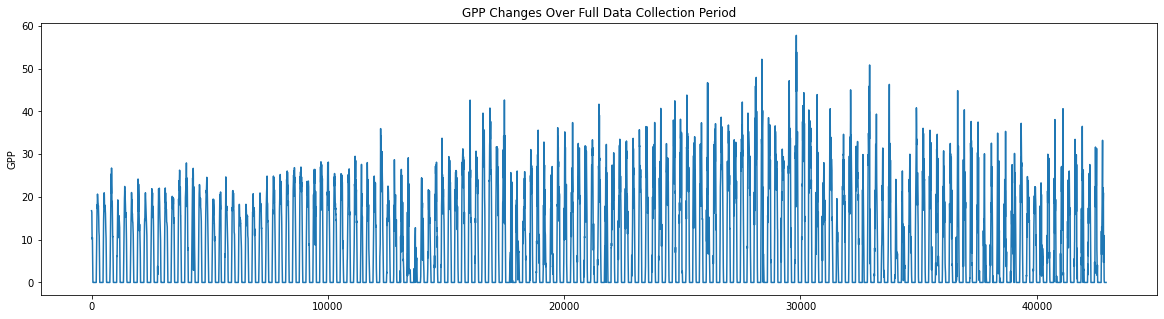

<Figure size 1440x360 with 0 Axes>

In [106]:
import numpy as np
import matplotlib.pyplot as plt

csv_master_path = r"C:/Users/Peter/Desktop/Thermo_R_Code/FinalThermo/new2/csvdataFULL/BCIML_Dataset/populatedGPPsFULL.csv"
#csv_master_path = r"C:/Users/Peter/Desktop/Thermo_R_Code/FinalThermo/new2/csvdata10000/populatedGPPs.csv"
data_info = pd.read_csv(csv_master_path)
GPP_arr = np.asarray(data_info.iloc[:,1])
fig=plt.figure(figsize=(20.0, 5.0))
plt.plot(GPP_arr)
plt.ylabel('GPP')
plt.title("GPP Changes Over Full Data Collection Period")
plt.figure(figsize=(20,5))
os.chdir(r"C:/Users/Peter/Desktop/Thermo_R_Code/FinalThermo/new2")
plt.show()
os.chdir(csvdataLocation)

my_dpi=96

fig.savefig('Full GPP Changes.png', dpi=my_dpi*5)